In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.special import boxcox1p
from scipy.stats import norm,skew
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from scipy import stats
import warnings
import math
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from IPython.display import display

warnings.filterwarnings('ignore')
%matplotlib inline
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
#df_test.head()

In [2]:
target = df_train.SalePrice 

In [3]:
def scatterplot(df,varx,vary):
    #scatter plot grlivarea/saleprice
    data = pd.concat([df[varx], df[vary]], axis=1)
    data.plot.scatter(x=varx, y=vary);
    plt.show()
    
def plot_histogram(dataf , dofit=False):
    # Fit a normal distribution to the data:


    q25, q75 = np.nanpercentile(dataf, [25, 75])
    bin_width = 2 * (q75 - q25) * len(dataf.dropna()) ** (-1/3)
    bins = round((dataf.dropna().max() - dataf.dropna().min()) / bin_width)

    # Plot the histogram.
    plt.hist(dataf, bins=bins, density=True, alpha=0.6, color='g')

    # Plot the PDF.
    if dofit: 
        mu, std = norm.fit(dataf.dropna())
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)

        plt.plot(x, p, 'k', linewidth=2)
        title = "Fit results: mean = %.2f,  std = %.2f" % (mu, std)
        plt.title(title)

    plt.show()
    
#Score

kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
def rmse_cv_train(model,X_tr,y_tr):
    rmse= np.sqrt(-cross_val_score(model, X_tr, y_tr, scoring="neg_mean_squared_error",cv=kfolds))
    return(rmse)

def rmse_cv_test(model,X_te,y_te):
    rmse= np.sqrt(-cross_val_score(model, X_te, y_te,  scoring="neg_mean_squared_error",cv=kfolds))
    return(rmse)

# 1. Explorando os dados

In [4]:
df_train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
corr = df_train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

##  Tratamento inicial

Lidando com valores nulos

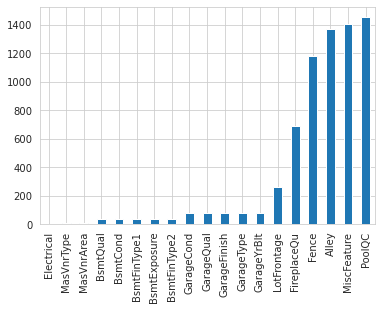

In [7]:
sns.set_style("whitegrid")
missing = df_train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

plt.show()

In [8]:
#O campo "id" não tem significado nenhum
df_train.drop(['Id'], axis=1, inplace=True)

# Alley : data description says NA means "no alley access"
# MasVnrType : NA most likely means no veneer
NA_to_none=["Alley","MasVnrType"]

for x in NA_to_none:
    df_train.loc[:, x] = df_train.loc[:, x].fillna("None")
    df_test.loc[:, x] = df_test.loc[:, x].fillna("None")

# BedroomAbvGr : NA most likely means 0
# EnclosedPorch : NA most likely means no enclosed porch
# HalfBath : NA most likely means no half baths above grade
# KitchenAbvGr : NA most likely means 0
# LotFrontage : NA most likely means no lot frontage
# OpenPorchSF : NA most likely means no open porch
# ScreenPorch : NA most likely means no screen porch
# TotRmsAbvGrd : NA most likely means 0

NA_to_0=["BedroomAbvGr","BsmtFullBath","BsmtHalfBath","BsmtUnfSF","Fireplaces","EnclosedPorch","GarageArea","GarageCars",
         "HalfBath","KitchenAbvGr","LotFrontage","MasVnrArea","MiscVal","OpenPorchSF","PoolArea","ScreenPorch","TotRmsAbvGrd",
         "WoodDeckSF"]
for x in NA_to_0:
    df_train.loc[:, x] = df_train.loc[:, x].fillna(0)
    df_test.loc[:, x] = df_test.loc[:, x].fillna(0)
    
    
# BsmtQual etc : data description says NA for basement features is "no basement"
NA_to_No= ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1","BsmtFinType2","CentralAir","Fence","FireplaceQu",
           "GarageType","GarageFinish","GarageQual","GarageCond","MiscFeature","PavedDrive","PoolQC"]

for x in NA_to_No:
    df_train.loc[:, x] = df_train.loc[:, x].fillna("No")
    df_test.loc[:, x] = df_test.loc[:, x].fillna("No")

    
NA_to_Normal=["Condition1","Condition2","SaleCondition"]
for x in NA_to_Normal:
    df_train.loc[:, x] = df_train.loc[:, x].fillna("Normal")
    df_test.loc[:, x] = df_test.loc[:, x].fillna("Normal")
    
NA_to_TA=["ExterCond","ExterQual","HeatingQC","KitchenQual"]
for x in NA_to_TA:
    df_train.loc[:, x] = df_train.loc[:, x].fillna("TA")
    df_test.loc[:, x] = df_test.loc[:, x].fillna("TA")

# Functional : data description says NA means typical
df_train.loc[:, "Functional"] = df_train.loc[:, "Functional"].fillna("Typ")
df_test.loc[:, "Functional"] = df_test.loc[:, "Functional"].fillna("Typ")

# LotShape : NA most likely means regular
df_train.loc[:, "LotShape"] = df_train.loc[:, "LotShape"].fillna("Reg")
df_test.loc[:, "LotShape"] = df_test.loc[:, "LotShape"].fillna("Reg")

# Utilities : NA most likely means all public utilities
df_train.loc[:, "Utilities"] = df_train.loc[:, "Utilities"].fillna("AllPub")
df_test.loc[:, "Utilities"] = df_test.loc[:, "Utilities"].fillna("AllPub")

# Separando as features

In [9]:
categorical_features = df_train.select_dtypes(include = ["object"]).columns
numerical_features = df_train.select_dtypes(exclude = ["object"]).columns

train_num = df_train[numerical_features]
train_cat = df_train[categorical_features]

## Variáveis Categóricas

Separando variáveis numéricas de variáveis categóricas:

As variáveis categóricas são aquelas que apresentam um número limitado de valores possíveis, como em "PavedDrive":

**PavedDrive - se a entrada para a garagem é asfaltada**
>Y - asfaltada<br>
P - parcialmente asfaltada<br>
N - não asfaltada
   
Às vezes as categorias podem ser representadas por números, mas estes não têm sentido numérico, como em "OverallCond":

**OverallCond - avalia a condição geral da casa**
>10 - Muito Excelente<br>
9 - Excelente<br>
8 - Muito Bom<br>
7 - Bom<br>
6 - Acima da Média<br>
5 - Média<br>
4 - Abaixo da Média<br>
3 - Aceitável<br>
2 - Ruim<br>
1 - Muito Ruim

## Variáveis Numéricas

São aquelas que possuem valores numéricos e fazem sentido quantitativo, como "SalePrice":

## Transformação numérica de variáveis categóricas

Para que seja possível utilizar as variáveis categóricas na formação do modelo, é necessário primeiro transformá-las em números, técnica chamada *encoding*.

**One Hot Encoding** - utilizada geralmente em variáveis categóricas que não possuem ordem/ranking, ex:

Heating - type of heating
>Floor<br>
GasA<br>
GasW<br>
Grav<br>
OthW<br>
Wall

No One Hot Encoding a coluna que se procura converter é dividida em n colunas, em que n é o número de categorias da coluna original. Estas novas colunas são preenchidas somente com 1s e 0s.

**Ordinal Encoding** - utilizada quando a variável categórica apresenta ordem/ranking, ex:

HeatingQC - heating quality and condition

>Ex - Excellent<br>
Gd - Good<br>
TA - Average/Typical<br>
Fa - Fair<br>
Po - Poor

No Ordinal Encoding, cada valor (categoria) da coluna original é convertida em um número inteiro de 0 a n-1, onde n é o número de categorias.

In [10]:
# Criando "Dummy Features" para vaiáveis categóricas
print("NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))
train_cat = pd.get_dummies(train_cat)
print("Remaining NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))
train_cat.head(10)

NAs for categorical features in train : 1
Remaining NAs for categorical features in train : 0


MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  \
0                 0            0            0            1            0   
1                 0            0            0            1            0   
2                 0            0            0            1            0   
3                 0            0            0            1            0   
4                 0            0            0            1            0   
5                 0            0            0            1            0   
6                 0            0            0            1            0   
7                 0            0            0            1            0   
8                 0            0            0            0            1   
9                 0            0            0            1            0   

   Street_Grvl  Street_Pave  Alley_Grvl  Alley_None  Alley_Pave  ...  \
0            0            1           0           1           0  ...   
1            0            1           0           1           0  ...   
2            0            1           0           1           0  ...   
3            0            1           0           1           0  ...   
4            0            1           0           1           0  ...   
5            0            1           0           1           0  ...   
6            0            1           0           1           0  ...   
7            0            1           0           1           0  ...   
8            0            1           0           1           0  ...   
9            0            1           0           1           0  ...   

   SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0               0             0             0            1   
1               0             0             0            1   
2               0             0             0            1   
3               0             0             0            1   
4               0             0             0            1   
5               0             0             0            1   
6               0             0             0            1   
7               0             0             0            1   
8               0             0             0            1   
9               0             0             0            1   

   SaleCondition_Abnorml  SaleCondition_AdjLand  SaleCondition_Alloca  \
0                      0                      0                     0   
1                      0                      0                     0   
2                      0                      0                     0   
3                      1                      0                     0   
4                      0                      0                     0   
5                      0                      0                     0   
6                      0                      0                     0   
7                      0                      0                     0   
8                      1                      0                     0   
9                      0                      0                     0   

   SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
0                     0                     1                      0  
1                     0                     1                      0  
2                     0                     1                      0  
3                     0                     0                      0  
4                     0                     1                      0  
5                     0                     1                      0  
6                     0                     1                      0  
7                     0                     1                      0  
8                     0                     0                      0  
9                     0                     1                      0  

[10 rows x 265 columns]

In [11]:
# Substituindo os valores que faltam pela mediana
print("NAs for numerical features in train : " + str(train_num.isnull().values.sum()))
train_num = train_num.fillna(train_num.median())
print("Remaining NAs for numerical features in train : " + str(train_num.isnull().values.sum()))

NAs for numerical features in train : 81
Remaining NAs for numerical features in train : 0


In [12]:
train1 = pd.concat([train_num, train_cat], axis = 1)
features = train1.columns.drop("SalePrice") #No final o preço de venda deverá ser separado das features para fazer a
                      

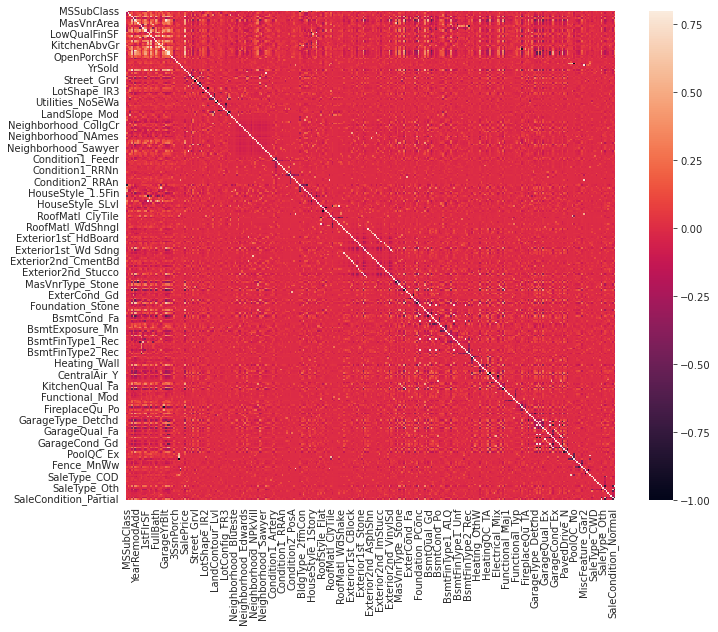

In [13]:
corrmat = train1.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

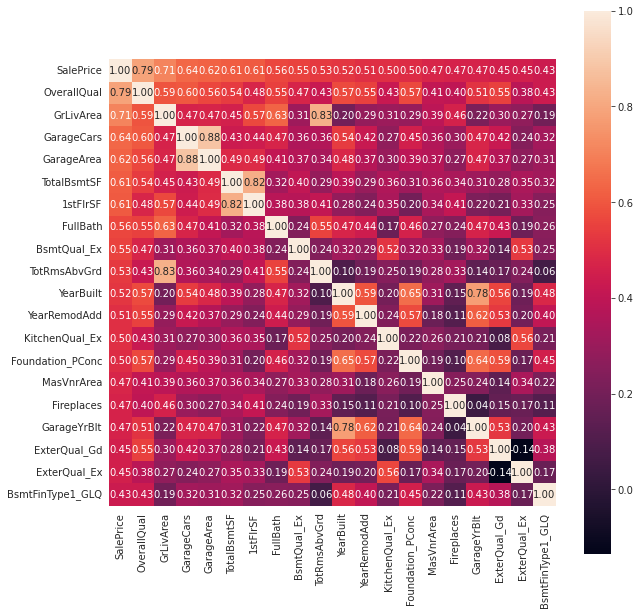

In [14]:
#Features com mais correlação com o SalePrice
k = 20 
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train1[cols].values.T)
#sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(10,10))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Outras variáveis com alta correlação entre si: <br>

TotalBsmtSF e 1stFlrSF<br>
TotRmsAbvGrd e GrLivArea<br>
GarageCars e GarageArea<br>
YearBuilt e GarageYrBlt<br>

Foundation_PConc, YearBuilt, GarageYrBlt<br>
GrLivArea e FullBath <br>

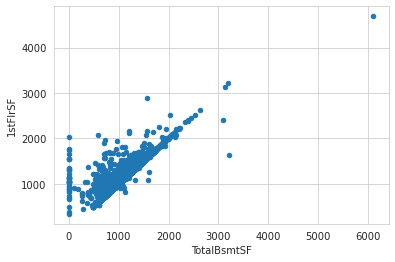

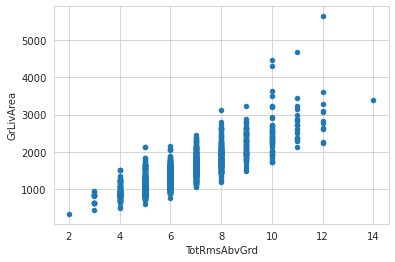

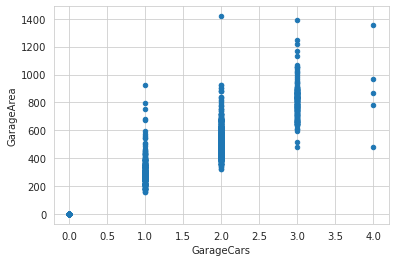

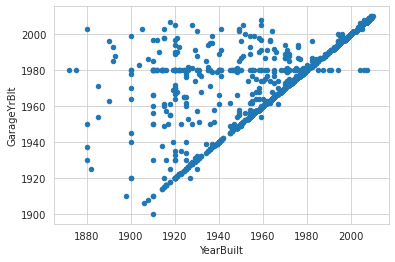

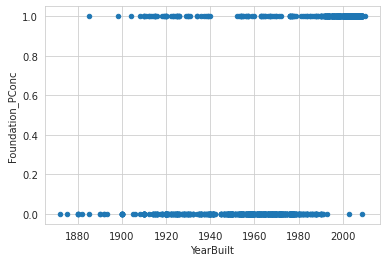

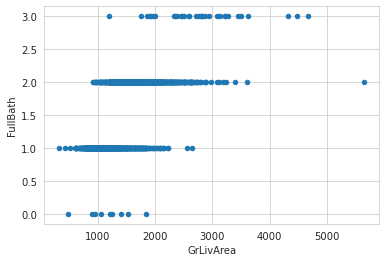

In [15]:
scatterplot(train1,"TotalBsmtSF",  "1stFlrSF")
scatterplot(train1,"TotRmsAbvGrd",  "GrLivArea")
scatterplot(train1,"GarageCars",  "GarageArea")
scatterplot(train1,"YearBuilt",  "GarageYrBlt")

scatterplot(train1,"YearBuilt",  "Foundation_PConc")
scatterplot(train1,"GrLivArea",  "FullBath")

## Observações iniciais

Distribuição das casas com todos os tipos de fundação:


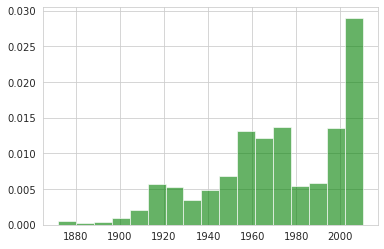

Distribuição das casas com fundação de concreto:


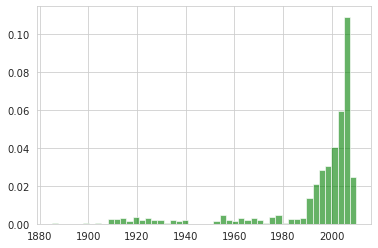

Distribuição das casas com outros tipos Fundação (excluindo concreto):


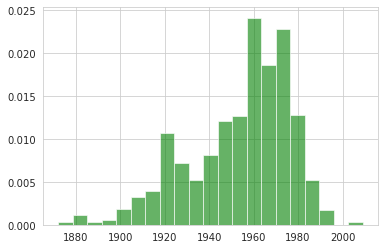

In [16]:
#Separando somente as casas com fundação de concreto das que não tem fundação de concreto
onlyconcfound = train1[train1.Foundation_PConc == 1]
onlynonconcfound = train1[train1.Foundation_PConc != 1]

print("Distribuição das casas com todos os tipos de fundação:")
plot_histogram(train1["YearBuilt"])
print("Distribuição das casas com fundação de concreto:")
plot_histogram(onlyconcfound["YearBuilt"])
print("Distribuição das casas com outros tipos Fundação (excluindo concreto):")
plot_histogram(onlynonconcfound["YearBuilt"])

As casas com fundação de concreto são, no geral, mais recentes

Todas as casas:


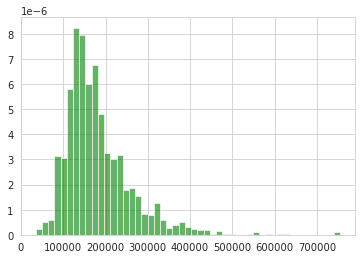

valor médio total: 180921.19589041095

Casas com fundação de concreto:


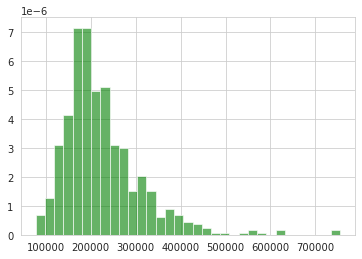

valor médio c/ fund de concreto: 225230.44204018547
diferênça (%): 24.49090938831395

Casas com outros tipos de fundação:


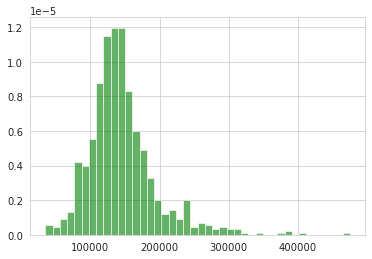

valor médio c/ fund de concreto: 145659.1020910209
diferênça (%): -19.49030550336915



In [17]:
# comparando a média dos preços de venda das casas com fundação de concreto com a médida de preço
#do resto das casas

#todas as casas:
print("Todas as casas:")
plot_histogram(train1["SalePrice"])
totmed=train1["SalePrice"].mean()
print("valor médio total: "+ str(totmed) +"\n")

#apenas as que tem fundação de concreto:
print("Casas com fundação de concreto:")
plot_histogram(onlyconcfound["SalePrice"])
concmed=onlyconcfound["SalePrice"].mean()
difconc=((concmed- totmed)/totmed)*100
print("valor médio c/ fund de concreto: "+ str(concmed))
print("diferênça (%): " + str( difconc )+"\n")

#apenas as que não tem fundação de concreto
print("Casas com outros tipos de fundação:")
plot_histogram(onlynonconcfound["SalePrice"])
nonconcmed=onlynonconcfound["SalePrice"].mean()
difnonconc=((nonconcmed- totmed)/totmed)*100
print("valor médio c/ fund de concreto: "+ str(nonconcmed))
print("diferênça (%): " + str( difnonconc )+"\n")

<AxesSubplot:xlabel='Foundation', ylabel='SalePrice'>

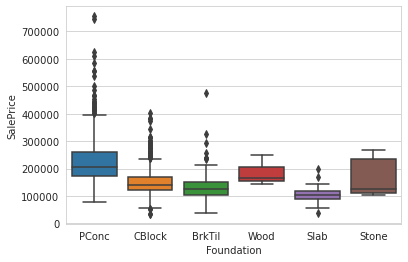

In [18]:
sns.boxplot(x=df_train["Foundation"],y=df_train["SalePrice"])

Ordem de valor médio: "Slab" = 1, "BrkTil" = 2, "CBlock" = 3, "Stone"= 4, "Wood"= 5, "PConc"= 6

O tipo de fundação pode ter um impacto no preço da casa. Isso sugere que podemos talvez tentar dar um valor numérico para cada tipo de fundação 

## $1^{a}$ Regressão

In [19]:
lr = LinearRegression()
#X_train, X_test, y_train, y_test = train_test_split(train, target, test_size = 0.1, random_state = 0)
y_train=target
X_train=train1[features]
print(X_train.shape)
print(y_train.shape)
lr = LinearRegression()
lr.fit(X_train, y_train)

(1460, 301)
(1460,)


LinearRegression()

### Distribuição dos erros

In [20]:
y_train_pred = lr.predict(X_train)
error = y_train_pred - y_train

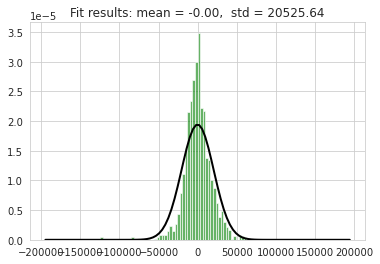

score: 0.933198674872362


count    1.460000e+03
mean    -5.980239e-12
std      2.053267e+04
min     -1.769931e+05
25%     -9.607436e+03
50%     -1.165405e-06
75%      9.064987e+03
max      1.769931e+05
Name: SalePrice, dtype: float64

In [21]:
plot_histogram(error, dofit=True)
print("score: "+ str(lr.score(X_train, y_train)))
#print("RMSE on Training set :", rmse_cv_train(lr).mean())
error.describe()
#print("RMSE on Test set :", rmse_cv_test(lr).mean())

# 2. Retornando para os dados

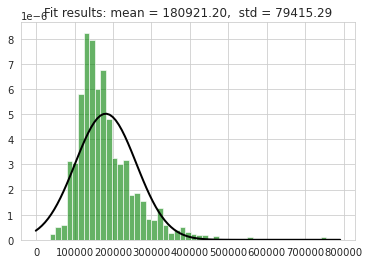

In [22]:
plot_histogram(df_train["SalePrice"],dofit =True)

## Função logarítimo

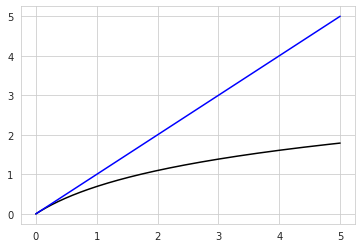

In [23]:
xl=np.linspace(0,5,300)
ylog=np.log1p(xl)# log(1+x)
plt.plot(xl,ylog,"k-",xl,xl,"b-")
plt.show()

A função Logarítimo tende a diminuir aumentar os valores próximos da origem e diminuir os valores que estão longe

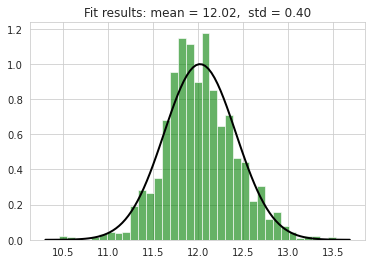

In [24]:
logSalePrice=np.log1p(df_train["SalePrice"])
plot_histogram(logSalePrice, dofit = True)

In [25]:
target = logSalePrice

## $2^a$ Regressão

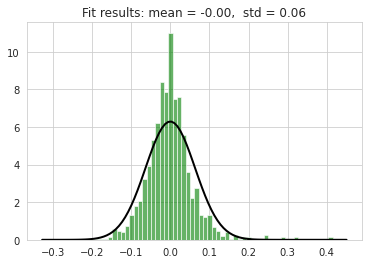

score: 0.9751906704453202
RMSE on Training set : 0.08946995907327783
RMSE on Test set : 0.11930981118391362


count    1.314000e+03
mean    -2.676702e-16
std      6.341132e-02
min     -2.921561e-01
25%     -3.356627e-02
50%     -2.450709e-03
75%      2.660709e-02
max      4.151997e-01
Name: SalePrice, dtype: float64

In [26]:
lr = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(train1, target, test_size = 0.1, random_state = 0)
#print(X_train.shape)
#print(y_train.shape)
#x_train=train[features]

#X_train=train1
#y_train=target
lr = LinearRegression()
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
error = y_train_pred - y_train
#error = y_train_pred - y
plot_histogram(error,dofit= True)
print("score: "+ str(lr.score(X_train, y_train)))

print("RMSE on Training set :", rmse_cv_train(lr,X_train,y_train).mean())
print("RMSE on Test set :", rmse_cv_test(lr,X_test,y_test).mean())
error.describe()

# 3. Tratando os valores das features:

Primeiramente, algumas features relacionadas à qualidade ou condição da casa foram anteriormente agrupadas como features categóricas, mas elas podem ser convertidas para números (como se fosse uma nota de avaliação)


In [27]:
quality_features = {"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       #O número adicionado aqui depende da média do preço das casas com cada tipo de fundação
                       "Foundation" : {"Slab" : 1, "BrkTil" : 2, "CBlock" : 3, "Stone": 4, "Wood": 5, "PConc": 6},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       #"Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}
                       }

df_train = df_train.replace(quality_features)
df_test = df_test.replace(quality_features)

numerical_categories = {"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      }
df_train = df_train.replace(numerical_categories)
df_test = df_test.replace(numerical_categories)

## Foundation

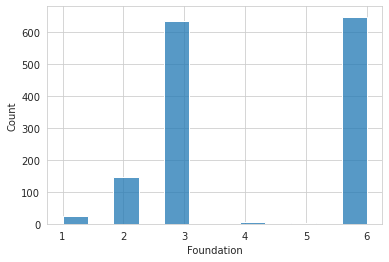

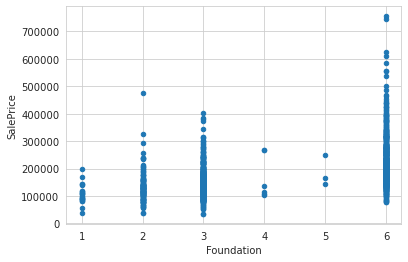

In [28]:
sns.histplot(df_train["Foundation"])
scatterplot(df_train, "Foundation","SalePrice")

## Bsmt

<AxesSubplot:xlabel='BsmtQual', ylabel='Count'>

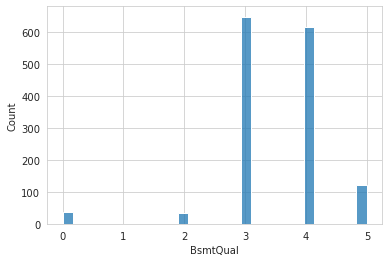

In [29]:
sns.histplot(df_train["BsmtQual"])

Em geral, como o custo de uma casa é bastante alto então as casas de qualidade muito baixa provavelmente não chegam a ser vendidas, como o dataset trata somente das casas que foram vendidas é de se esperar que as features de qualidade dessas casas estejam. Talvez não devessemos esperar que essas features de qualidade sigam a distribuição normal

In [30]:
corr = df_train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice.head(20))

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
ExterQual       0.682639
KitchenQual     0.659600
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
BsmtQual        0.585207
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
FireplaceQu     0.520438
YearRemodAdd    0.507101
Foundation      0.505503
GarageYrBlt     0.486362
MasVnrArea      0.472614
Fireplaces      0.466929
HeatingQC       0.427649
Name: SalePrice, dtype: float64


## Separando novamente as features categóricas das features numéricas

In [31]:
categorical_features = df_train.select_dtypes(include = ["object"]).columns
categorical_featuressp=categorical_features.tolist()+["SalePrice"]
numerical_features = df_train.select_dtypes(exclude = ["object"]).columns

testids=df_test["Id"]
test_num=df_test[numerical_features.drop("SalePrice")]
test_cat=df_test[categorical_features]

train_num = df_train[numerical_features]
train_cat = df_train[categorical_features]
#train_catsp = df_train[categorical_featuressp]

# Introdução de novas features

In [32]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [33]:
print(get_top_abs_correlations(train_num, 20))

GarageQual    GarageCond      0.959172
PoolArea      PoolQC          0.899924
GarageCars    GarageArea      0.882475
Fireplaces    FireplaceQu     0.863241
YearBuilt     GarageYrBlt     0.825667
GrLivArea     TotRmsAbvGrd    0.825489
TotalBsmtSF   1stFlrSF        0.819530
OverallQual   SalePrice       0.790982
BsmtFinType2  BsmtFinSF2      0.788986
OverallQual   ExterQual       0.726278
ExterQual     KitchenQual     0.716122
GrLivArea     SalePrice       0.708624
BsmtFinType1  BsmtFinSF1      0.695751
YearBuilt     Foundation      0.694441
2ndFlrSF      GrLivArea       0.687501
ExterQual     SalePrice       0.682639
Foundation    GarageYrBlt     0.679975
BedroomAbvGr  TotRmsAbvGrd    0.676620
OverallQual   KitchenQual     0.673331
KitchenQual   SalePrice       0.659600
dtype: float64


## Score features

In [34]:
scorefeatures={"OverallScore":["OverallQual","OverallCond"],
                 "PoolScore":["PoolArea","PoolQC"],
                 "GarageScore":["GarageArea","GarageCond","GarageQual"],
                 "ExterScore":["ExterQual","ExterCond"],
                 "KitchenScore":["KitchenAbvGr","KitchenQual"]}
for sf, feats in scorefeatures.items():
    prodtrain=1
    prodtest=1
    for feat in feats:
        prodtrain=prodtrain*train_num[feat]
        prodtest=prodtest*test_num[feat]
    train_num[sf]=prodtrain
    test_num[sf]=prodtest


### Analisando as distribuições e correlações entre as variáveis numéricas 

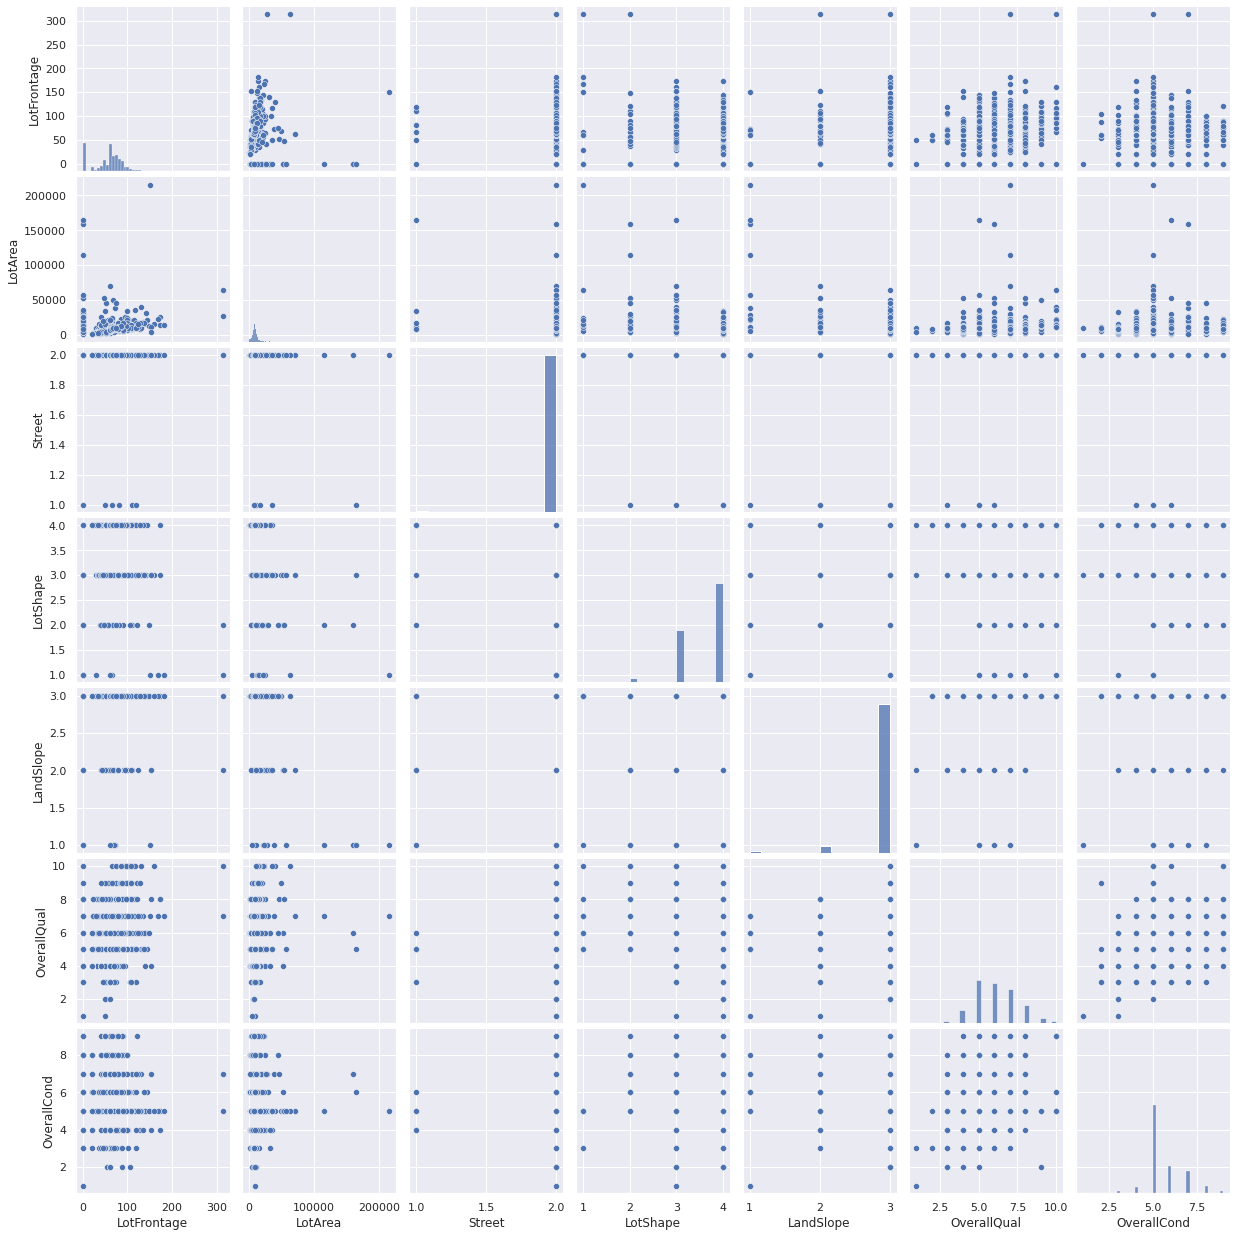

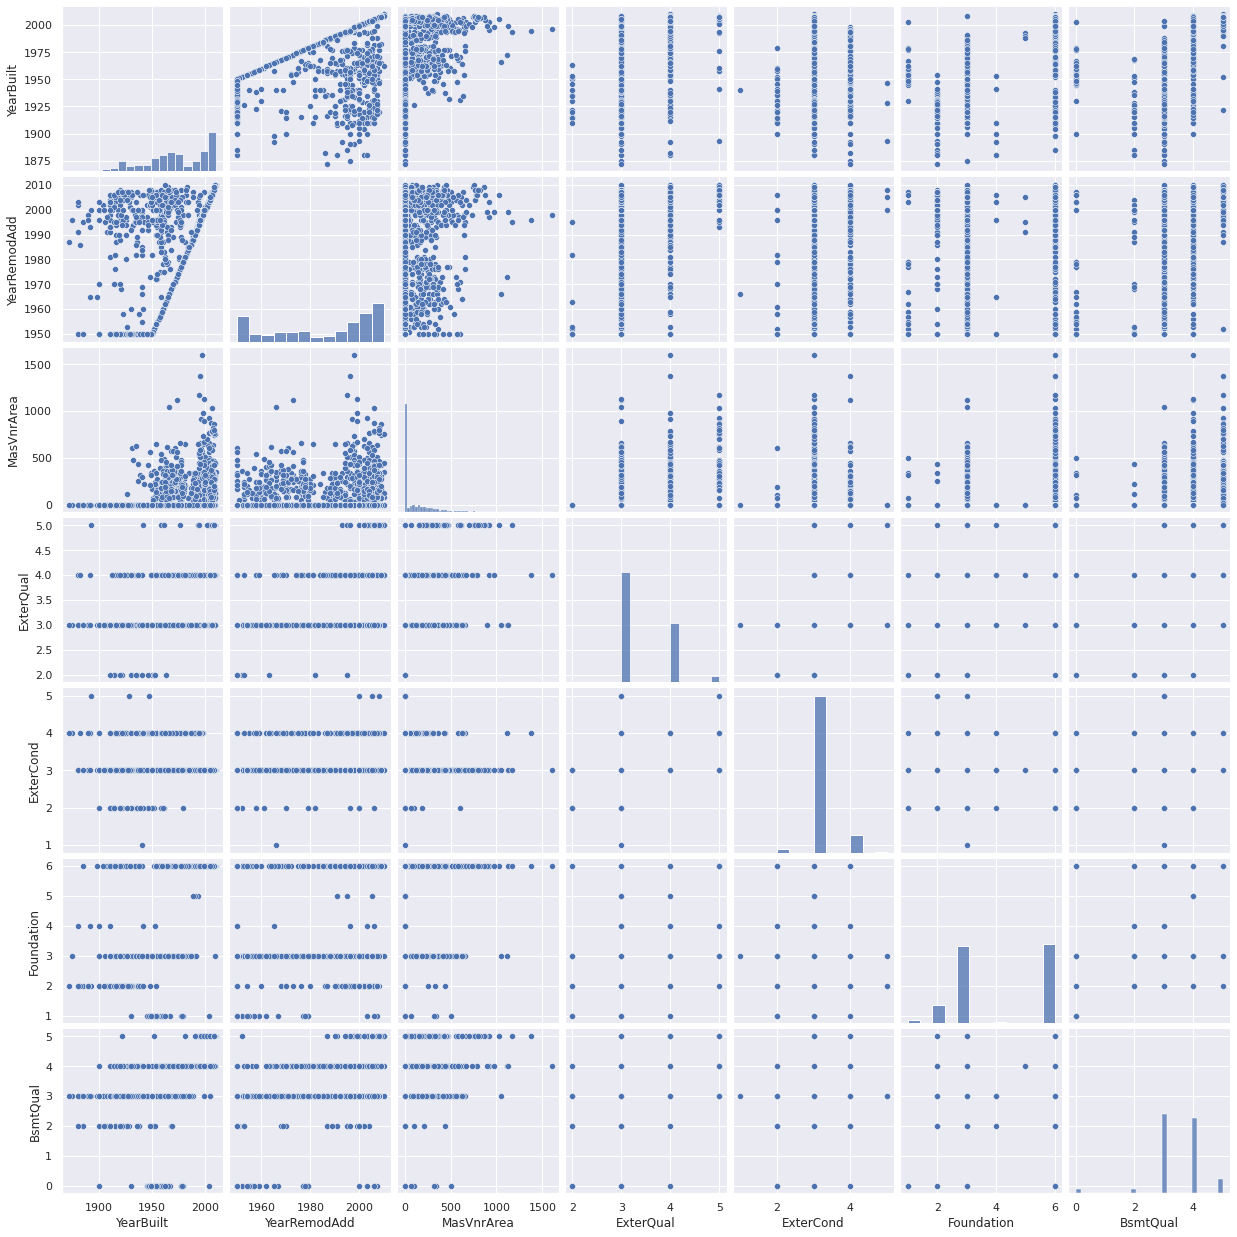

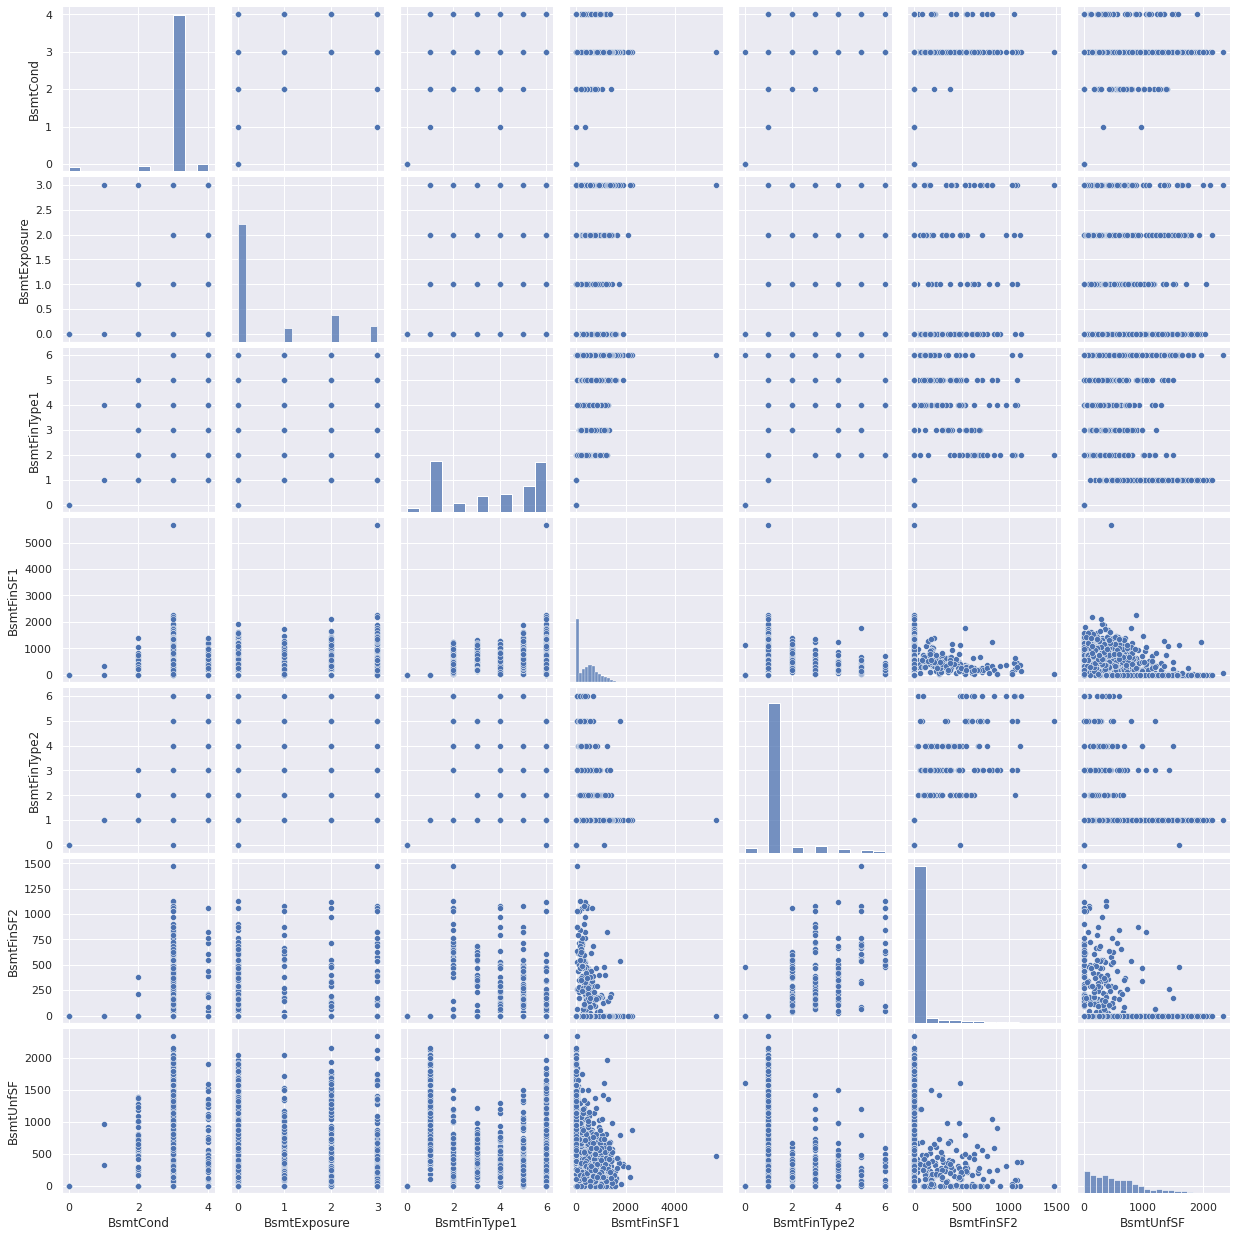

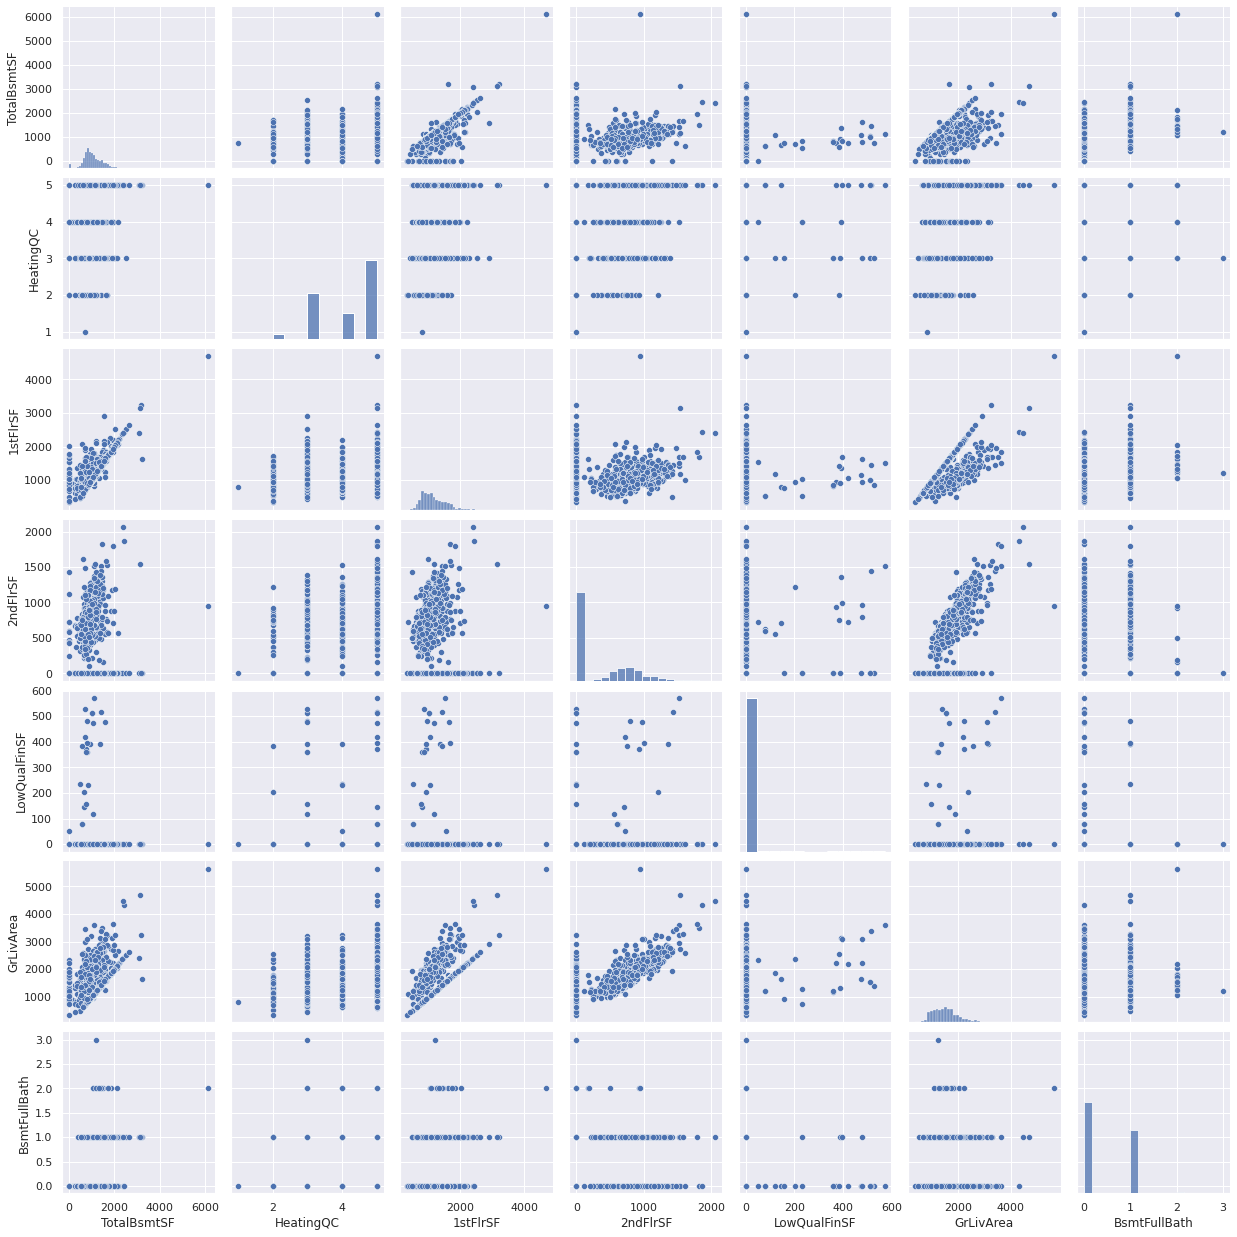

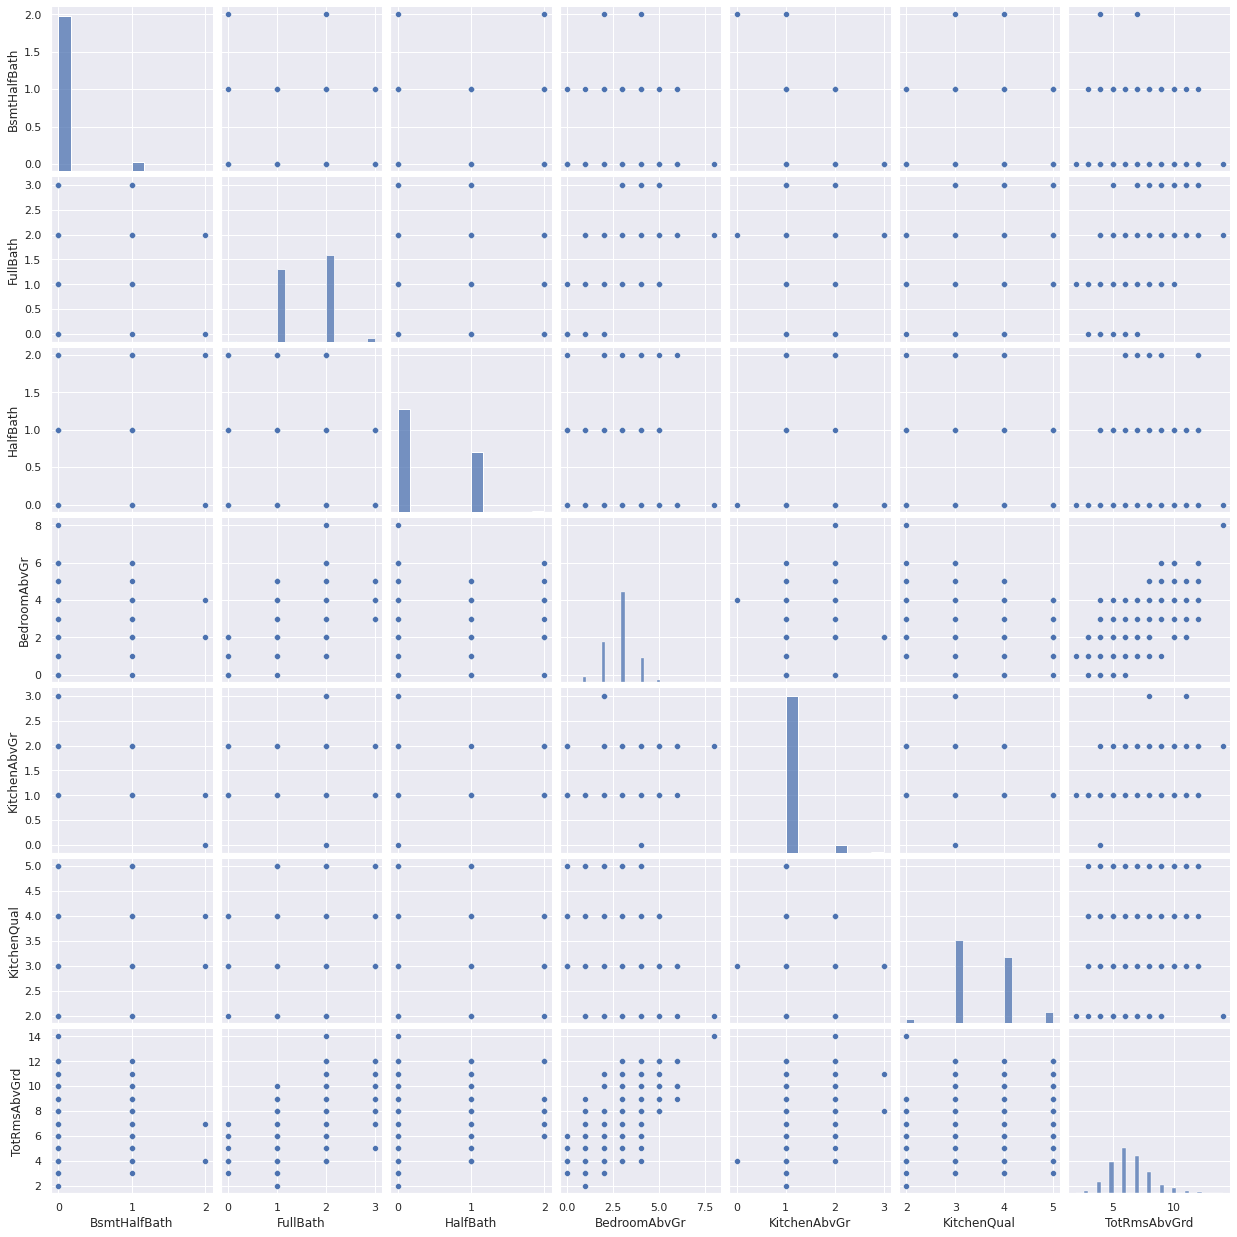

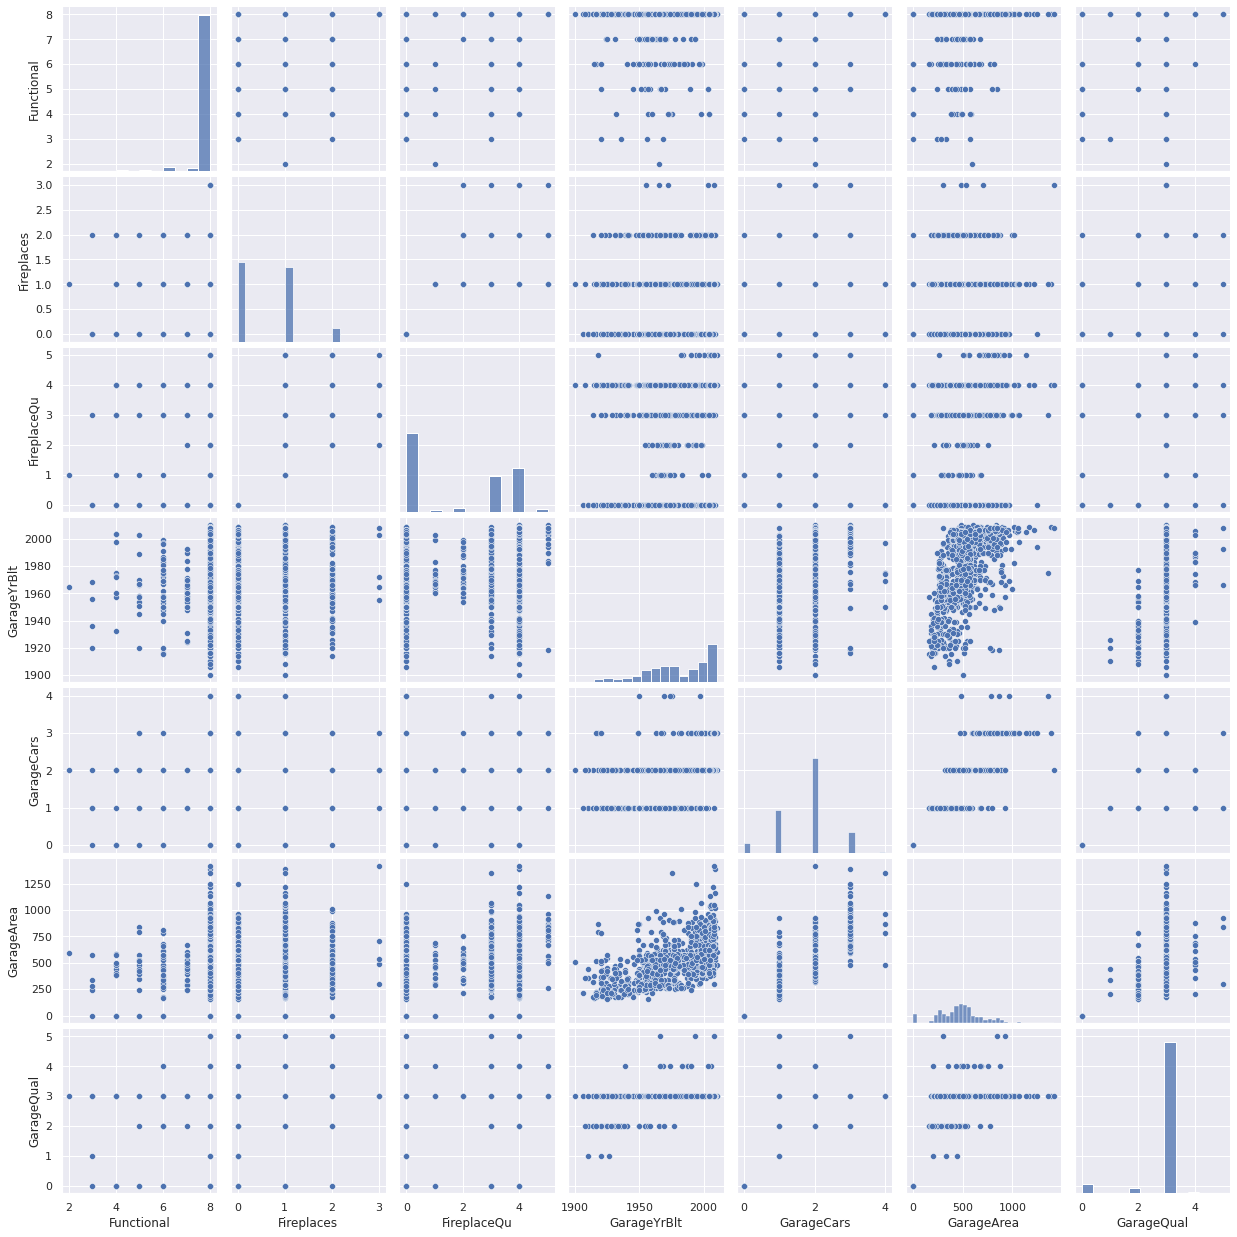

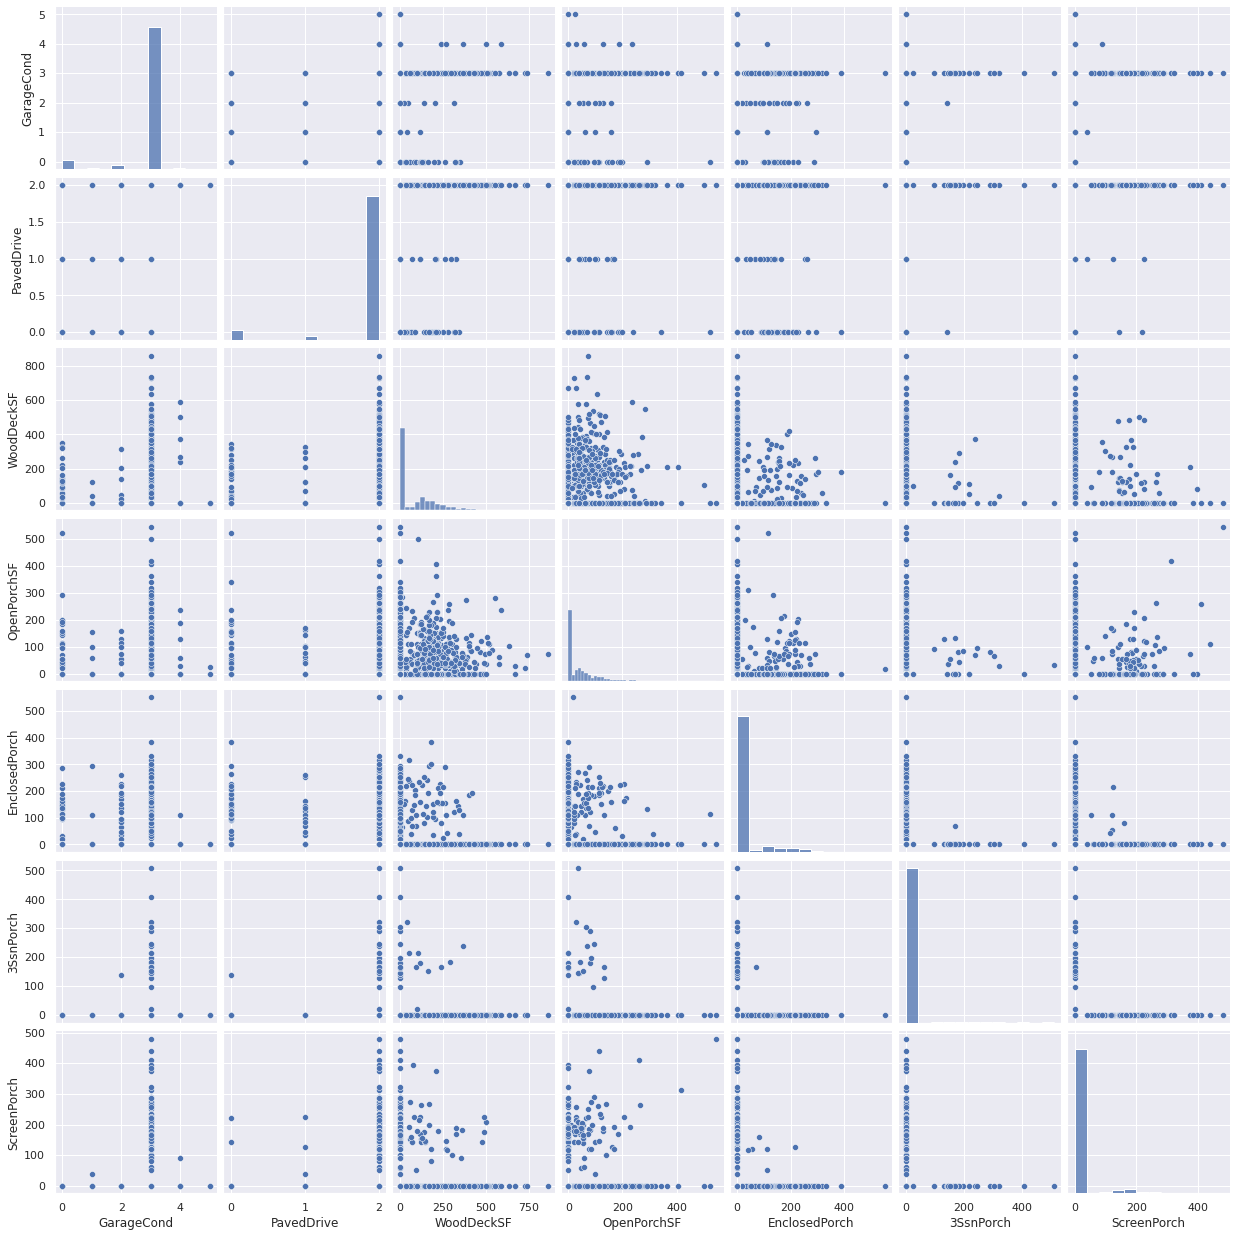

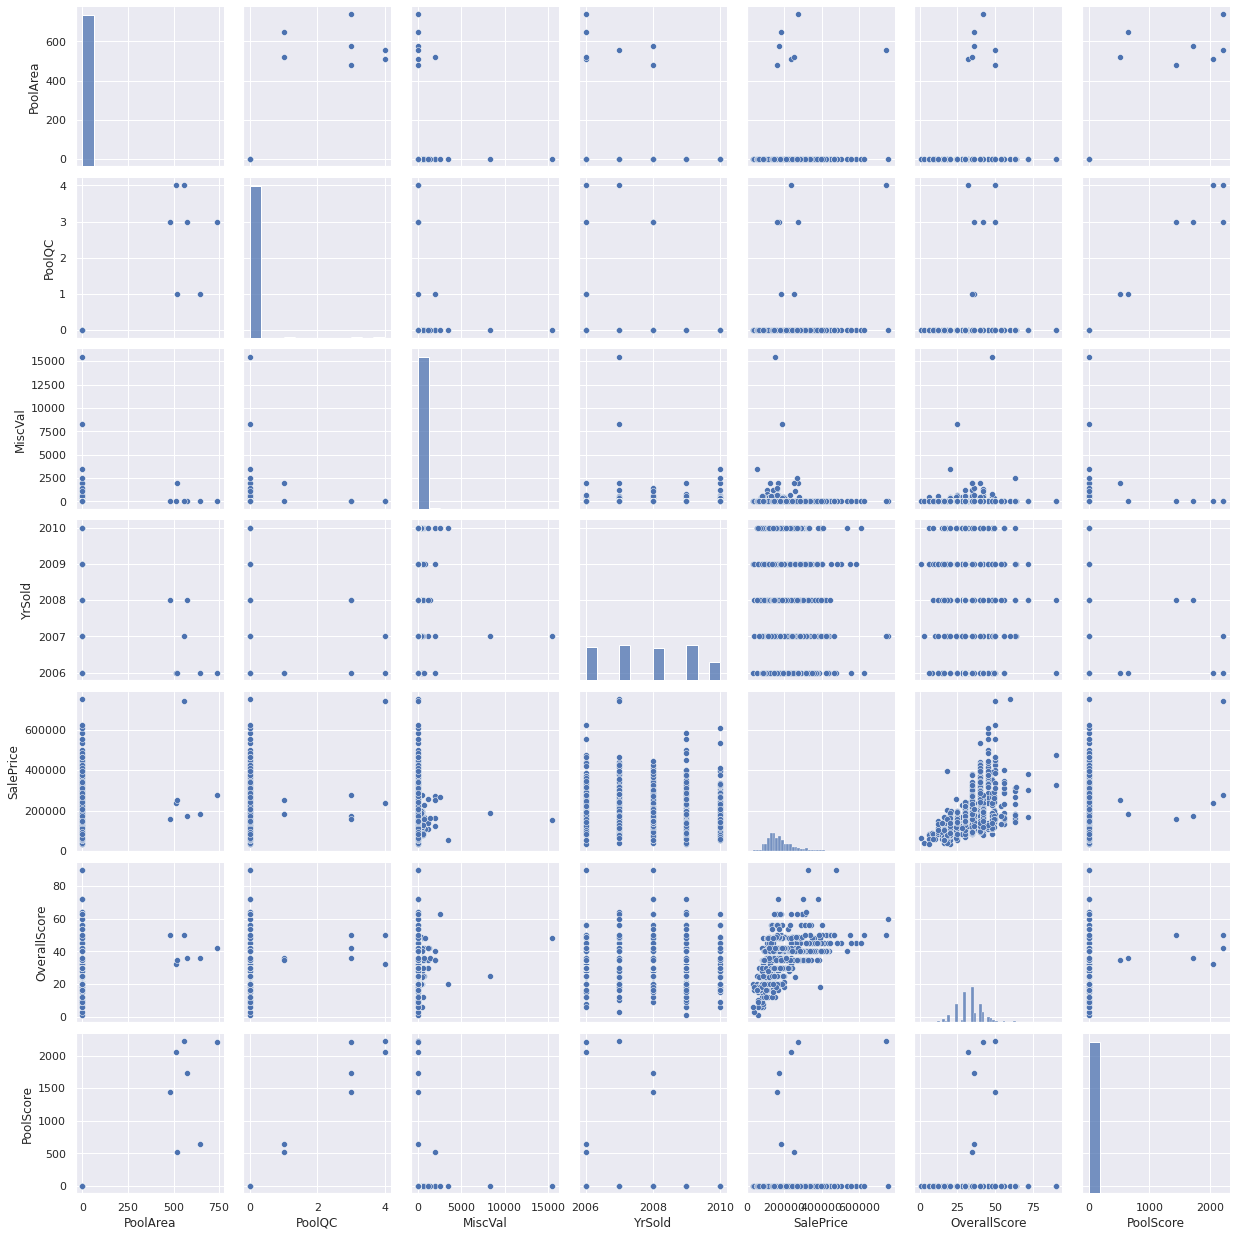

In [35]:
cls=train_num.columns


cols = [x for x in cls]
lcols=len(cols)
for x in range(lcols//7):
    sns.set()
    sns.pairplot(train_num[cols[x*7:min((x+1)*7,lcols)]], size = 2.5)
    plt.show()
    print("\n\n")

## Razão area/numero de quartos

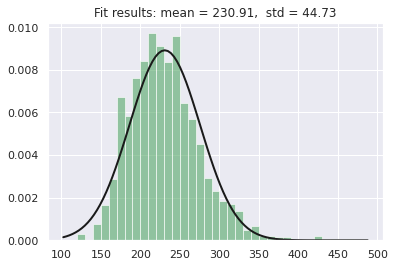

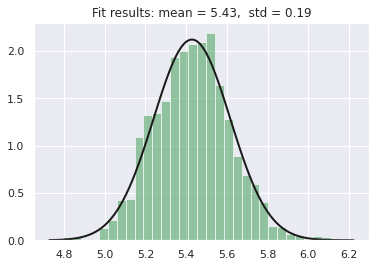

In [36]:
train_num["LivArea/RmsAbvGrd"] = train_num["GrLivArea"] / train_num["TotRmsAbvGrd"]
test_num["LivArea/RmsAbvGrd"] = test_num["GrLivArea"] / test_num["TotRmsAbvGrd"]
plot_histogram(train_num["LivArea/RmsAbvGrd"],dofit=True)
plot_histogram(np.log1p(train_num["LivArea/RmsAbvGrd"]),dofit=True)

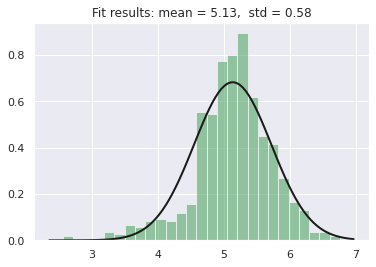

<AxesSubplot:xlabel='HasWoodDeck', ylabel='Count'>

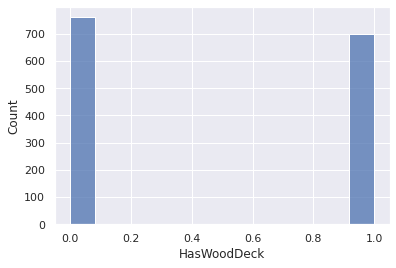

In [37]:
nonnormalfeats=["TotRmsAbvGrd","GarageScore","OverallQual","OverallCond","OverallScore","YrSold","MiscVal","PoolScore","ExterScore","KitchenScore","PoolQC","PoolArea","ScreenPorch","3SsnPorch","GarageYrBlt","KitchenAbvGr",
                "EnclosedPorch","PavedDrive","GarageCond","GarageQual","GarageYrBlt","GarageArea","GarageCars",
                "HalfBath","FullBath","BsmtHalfBath","BsmtFullBath","FireplaceQu","Fireplaces", "Functional",
                "KitchenQual","KitchenAbvGr","BedroomAbvGr","HeatingQC","BsmtFinType2","BsmtFinType1","BsmtExposure",
                 "BsmtCond","BsmtQual","Foundation","ExterCond","ExterQual","YearBuilt","LandSlope","Utilities","LotShape",
                 "Street","BsmtUnfSF","LowQualFinSF","BsmtFinSF2","YearRemodAdd","YearBuilt", "MasVnrArea"]
newfeats={"HasMiscfeat":["MiscVal"],
          "HasPool":["PoolArea","PoolQC"],
          "HasPorch":["ScreenPorch","3SsnPorch","EnclosedPorch","OpenPorchSF"],
          "HasWoodDeck":["WoodDeckSF"],"HasGarage":["GarageArea","GarageCars"], 
          "HasFireplace": ["Fireplaces","FireplaceQu"], "Has2ndFlr": ["2ndFlrSF"],
          "HasBsmt": ["BsmtQual","BsmtCond","TotalBsmtSF","BsmtFinSF2","BsmtFinSF1","BsmtExposure"],
          "HasMasVnr":["MasVnrArea"], "HasFrontage":["LotFrontage"],
         }

for newfeat, feats in newfeats.items():          
    train_cat[newfeat]=train_num.loc[:,feats[0]].apply(lambda x: 1 if x > 0 else 0)
    test_cat[newfeat]=test_num.loc[:,feats[0]].apply(lambda x: 1 if x > 0 else 0)
    
    #train_catsp[newfeat]=train_cat[newfeat]
    for feat in feats:
        meantrain=train_num.loc[:, feat].mean()
        meantest=test_num.loc[:, feat].mean()
        train_num.loc[:, feat] = train_num.loc[:, feat].replace(to_replace = 0, value = np.nan)
        test_num.loc[:, feat] = test_num.loc[:, feat].replace(to_replace = 0, value = np.nan)
        
plot_histogram(np.log1p(train_num["WoodDeckSF"]),dofit=True)
sns.histplot(train_cat["HasWoodDeck"])

### Variáveis relacionadas aos banheiros da casa

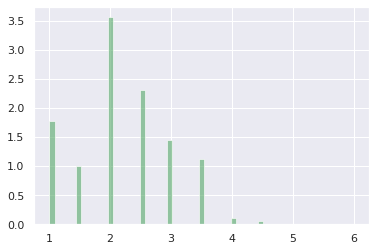

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


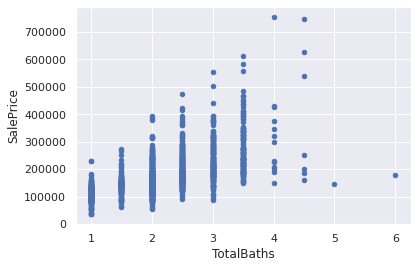

In [38]:
train_num["TotalBaths"] = train_num["BsmtFullBath"] + (0.5 * train_num["BsmtHalfBath"]) + train_num["FullBath"] + (0.5 * train_num["HalfBath"])
test_num["TotalBaths"] = test_num["BsmtFullBath"] + (0.5 * test_num["BsmtHalfBath"]) + test_num["FullBath"] + (0.5 * test_num["HalfBath"])
nonnormalfeats.append("TotalBaths")
plot_histogram(train_num["TotalBaths"])
scatterplot(train_num, "TotalBaths","SalePrice")

### Variáveis relacionadas ao porão (Bsmt)

In [39]:
#train_num["BsmtScore1"]=train_num["BsmtQual"]*train_num["BsmtUnfSF"]/(train_num["BsmtFinSF1"]+train_num["BsmtFinSF2"])
train_num["BsmtScore1"]=(train_num["BsmtQual"]*train_num["BsmtUnfSF"])
test_num["BsmtScore1"]=(test_num["BsmtQual"]*test_num["BsmtUnfSF"])

train_num["BsmtScore2"]=(train_num["BsmtQual"])*(train_num["BsmtFinSF1"]+train_num["BsmtFinSF2"]-train_num["BsmtUnfSF"])
test_num["BsmtScore2"]=(test_num["BsmtQual"])*(test_num["BsmtFinSF1"]+test_num["BsmtFinSF2"]-test_num["BsmtUnfSF"])
#train_num["BsmtScore1"].describe()
nonnormalfeats.append("BsmtScore1")

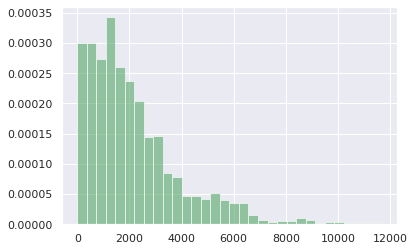

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


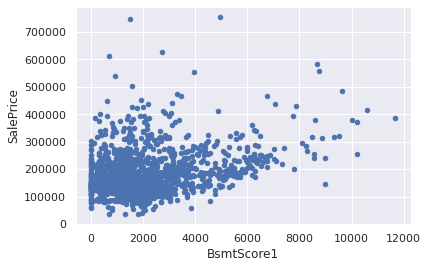

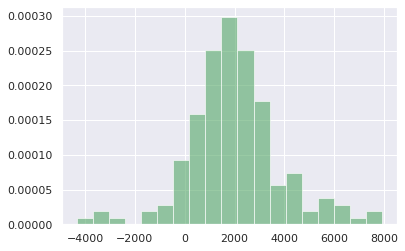

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


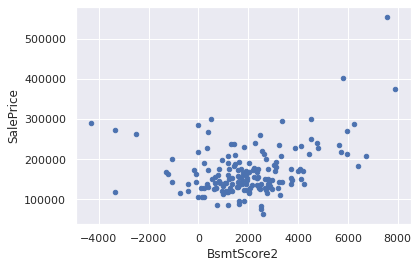

In [40]:
plot_histogram(train_num["BsmtScore1"])
scatterplot(train_num, "BsmtScore1","SalePrice")
plot_histogram(train_num["BsmtScore2"])
scatterplot(train_num, "BsmtScore2","SalePrice")

## Algumas features adicionais

In [41]:
#Algumas features adicionais que fazem sentido:
train_num["AllSF"] = train_num["GrLivArea"] + train_num["TotalBsmtSF"]
test_num["AllSF"] = test_num["GrLivArea"] + test_num["TotalBsmtSF"]

train_num["AllFlrsSF"] = train_num["1stFlrSF"] + train_num["2ndFlrSF"]
test_num["AllFlrsSF"] = test_num["1stFlrSF"] + test_num["2ndFlrSF"]

a=["AllSF","AllFlrsSF","BsmtScore2"]

for x in a:
    nonnormalfeats.append(x)

11


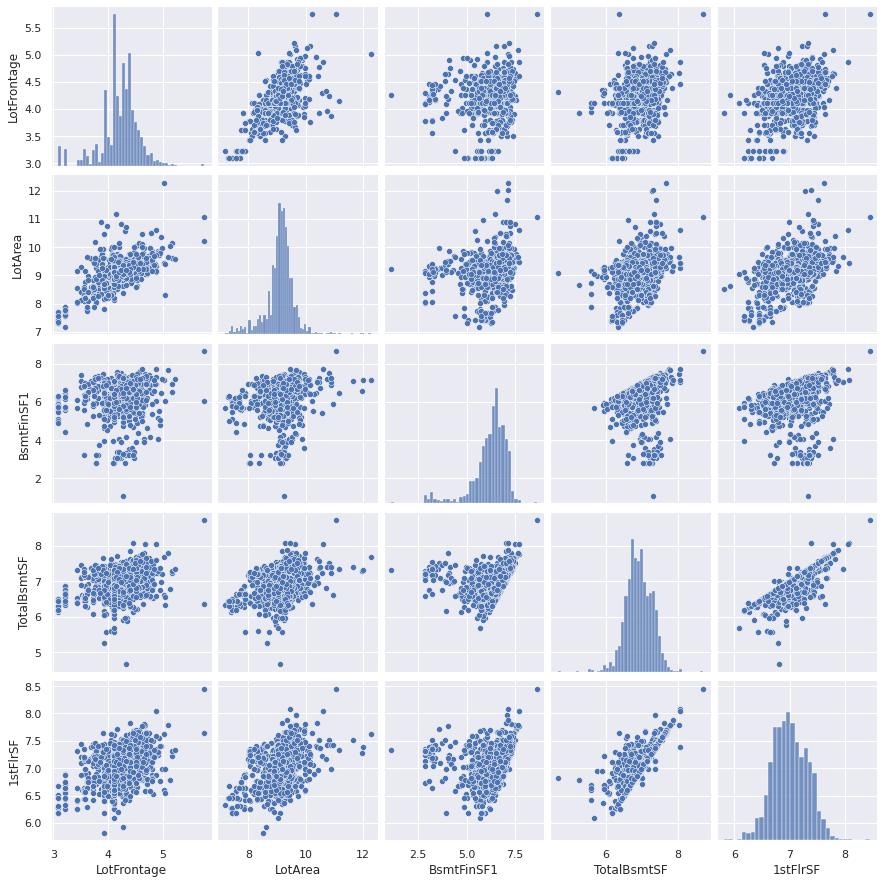

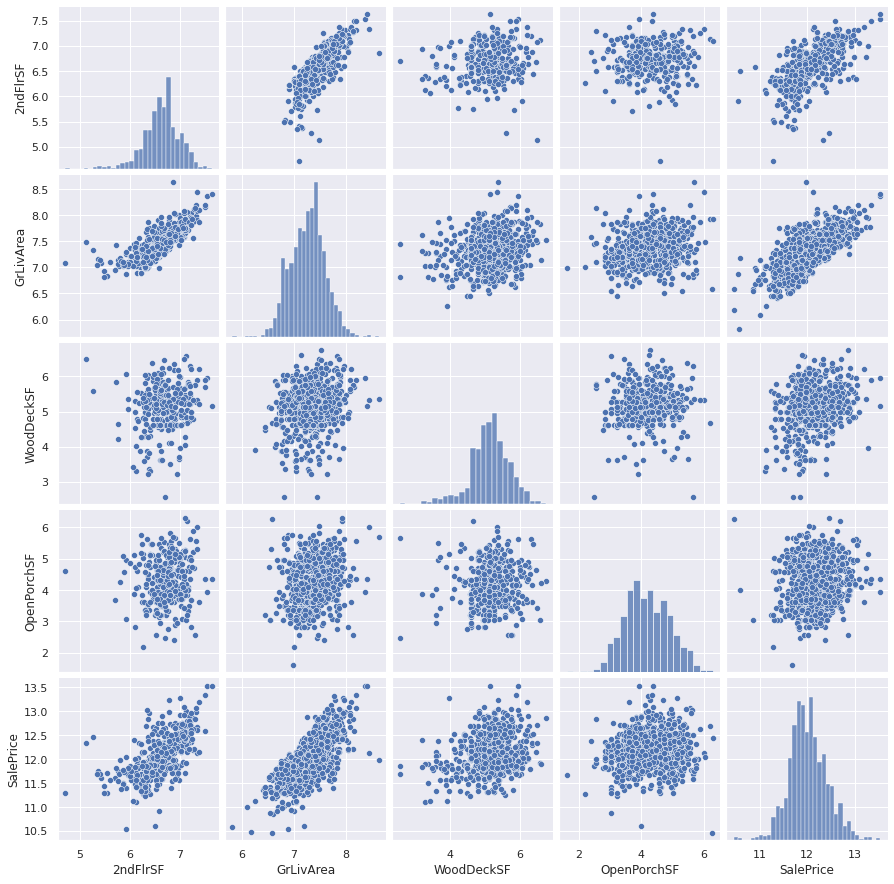

In [42]:
cls=train_num.columns
cols = [x for x in cls if (x not in nonnormalfeats)] #Eliminando as features que não devem seguir uma distribuição normal

#cols = [x for x in cls]
lcols=len(cols)
print(lcols)
for x in range(lcols//5):
    sns.set()
    sns.pairplot(np.log1p(train_num[cols[x*5:min((x+1)*5,lcols)]]), size = 2.5)
    plt.show()
    print("\n\n")

## Aplicando o logarítimo em todas as outras features

In [43]:
cls=train_num.columns
numerical_features=train_num.columns
normalize = [x for x in cls if (x not in nonnormalfeats)]
for feat in normalize:
    train_num[feat]=np.log1p(train_num[feat])
    if (feat != "SalePrice"):
        test_num[feat]=np.log1p(test_num[feat])

# Criando "Dummy Features" para variáveis categóricas

In [44]:
# Criando "Dummy Features" para variáveis categóricas
print("NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))
train_cat = pd.get_dummies(train_cat)

test_cat = pd.get_dummies(test_cat)
traincatcols=train_cat.columns
testcatcols=test_cat.columns
fakefeatures=[]
for x in traincatcols:
    if x not in testcatcols:
        test_cat[x]=0
        fakefeatures.append(x)
print(fakefeatures)
print("Remaining NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))
categorical_features=train_cat.columns
#train_cat.head(10)

NAs for categorical features in train : 1
['Utilities_NoSeWa', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'HouseStyle_2.5Fin', 'RoofMatl_ClyTile', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Exterior2nd_Other', 'Heating_Floor', 'Heating_OthW', 'Electrical_Mix', 'MiscFeature_TenC']
Remaining NAs for categorical features in train : 0


In [45]:
# Substituindo os valores que faltam pela média
print("NAs for numerical features in train : " + str(train_num.isnull().values.sum()))
#train_num = train_num.fillna(0)
train_num = train_num.fillna(train_num.median())
test_num = test_num.fillna(test_num.median())
#train_num = train_num.fillna(train_num.mean())
print("Remaining NAs for numerical features in train : " + str(train_num.isnull().values.sum()))

NAs for numerical features in train : 18401
Remaining NAs for numerical features in train : 0


## Padronizando as features

Agora como o problema dos zeros foi resolvido, podemos aplicar a padronização dos dados:

## <center>$x_{pad} =\frac{x-x_{med} }{\sigma} $<center>

In [46]:
#train_num = (train_num-train_num.mean())/(train_num.std())
#test_num = (test_num-test_num.mean())/(test_num.std())
train = pd.concat([train_num, train_cat], axis = 1)
test = pd.concat([test_num, test_cat], axis = 1)

train = (train-train.mean())/(train.std())
test = (test-test.mean())/(test.std())

## Eliminando features problemáticas

In [47]:
#Certas features tem valores que se repetem demais, alguns casos o valor que mais se repete (moda) chega a 
#representar mais de 99% dos dados 
over = []
for i in train.columns:
    counts = train[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(train) * 100 > 65:
        over.append(i)


over = list(over)
print(str(len(over))+" Dropped features: "+str(over))
newtrain = train.drop(over, axis=1)
#newtest = test.drop(over, axis=1)
test.head()

223 Dropped features: ['Street', 'LandSlope', 'ExterCond', 'BsmtCond', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PavedDrive', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal', 'PoolScore', 'BsmtScore2', 'HasMiscfeat', 'HasPool', 'HasPorch', 'HasGarage', 'HasBsmt', 'HasFrontage', 'MSSubClass_SC120', 'MSSubClass_SC160', 'MSSubClass_SC180', 'MSSubClass_SC190', 'MSSubClass_SC30', 'MSSubClass_SC40', 'MSSubClass_SC45', 'MSSubClass_SC50', 'MSSubClass_SC60', 'MSSubClass_SC70', 'MSSubClass_SC75', 'MSSubClass_SC80', 'MSSubClass_SC85', 'MSSubClass_SC90', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Alley_1', 'Alley_2', 'Alley_None', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'Utilities_AllPub', 'Utilities_NoSeWa', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConf

LotFrontage   LotArea    Street  LotShape  LandSlope  OverallQual  \
0     0.623609  0.561594  0.064238  0.702768   0.207921    -0.750844   
1     0.661183  0.970075  0.064238 -1.089783   0.207921    -0.054858   
2     0.387936  0.908102  0.064238 -1.089783   0.207921    -0.750844   
3     0.547049  0.257768  0.064238 -1.089783   0.207921    -0.054858   
4    -1.245150 -1.116586  0.064238 -1.089783   0.207921     1.337113   

   OverallCond  YearBuilt  YearRemodAdd  MasVnrArea  ...  RoofMatl_Membran  \
0     0.400629  -0.340828     -1.072517   -0.171145  ...               NaN   
1     0.400629  -0.439544     -1.214492   -0.888497  ...               NaN   
2    -0.497247   0.843770      0.678509   -0.171145  ...               NaN   
3     0.400629   0.876675      0.678509   -1.574660  ...               NaN   
4    -0.497247   0.679242      0.394559   -0.171145  ...               NaN   

   RoofMatl_Metal  RoofMatl_Roll  Exterior1st_ImStucc  Exterior1st_Stone  \
0             NaN            NaN                  NaN                NaN   
1             NaN            NaN                  NaN                NaN   
2             NaN            NaN                  NaN                NaN   
3             NaN            NaN                  NaN                NaN   
4             NaN            NaN                  NaN                NaN   

   Exterior2nd_Other  Heating_Floor  Heating_OthW  Electrical_Mix  \
0                NaN            NaN           NaN             NaN   
1                NaN            NaN           NaN             NaN   
2                NaN            NaN           NaN             NaN   
3                NaN            NaN           NaN             NaN   
4                NaN            NaN           NaN             NaN   

   MiscFeature_TenC  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN  

[5 rows x 274 columns]

In [48]:
droped99pc=['Street', 'Utilities', 'PoolArea', 'PoolQC', 'PoolScore', 'HasPool', 'MSSubClass_SC180', 'MSSubClass_SC40', 'MSSubClass_SC45', 'MSZoning_C (all)', 'LotConfig_FR3', 'Neighborhood_Blueste', 'Neighborhood_NPkVill', 'Neighborhood_Veenker', 'Condition1_PosA', 'Condition1_RRAe', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Artery', 'Condition2_Feedr', 'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'HouseStyle_1.5Unf', 'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf', 'RoofStyle_Flat', 'RoofStyle_Gambrel', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'RoofMatl_ClyTile', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_CBlock', 'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_CBlock', 'Exterior2nd_ImStucc', 'Exterior2nd_Other', 'Exterior2nd_Stone', 'Heating_Floor', 'Heating_Grav', 'Heating_OthW', 'Heating_Wall', 'Electrical_FuseP', 'Electrical_Mix', 'GarageType_2Types', 'GarageType_CarPort', 'Fence_MnWw', 'MiscFeature_Gar2', 'MiscFeature_Othr', 'MiscFeature_TenC', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_Oth', 'SaleCondition_AdjLand', 'SaleCondition_Alloca']
droped96pc=['Street', 'Utilities', 'LowQualFinSF', '3SsnPorch', 'PoolArea', 'PoolQC', 'MiscVal', 'PoolScore', 'HasMiscfeat', 'HasPool', 'HasBsmt', 'MSSubClass_SC180', 'MSSubClass_SC190', 'MSSubClass_SC40', 'MSSubClass_SC45', 'MSSubClass_SC75', 'MSSubClass_SC80', 'MSSubClass_SC85', 'MSSubClass_SC90', 'MSZoning_C (all)', 'MSZoning_RH', 'Alley_1', 'Alley_2', 'LandContour_HLS', 'LandContour_Low', 'LotConfig_FR2', 'LotConfig_FR3', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_Crawfor', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NPkVill', 'Neighborhood_NoRidge', 'Neighborhood_SWISU', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker', 'Condition1_Artery', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Artery', 'Condition2_Feedr', 'Condition2_Norm', 'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'HouseStyle_1.5Unf', 'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf', 'HouseStyle_SFoyer', 'RoofStyle_Flat', 'RoofStyle_Gambrel', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'RoofMatl_ClyTile', 'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_AsbShng', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Exterior1st_Stucco', 'Exterior1st_WdShing', 'Exterior2nd_AsbShng', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_BrkFace', 'Exterior2nd_CBlock', 'Exterior2nd_ImStucc', 'Exterior2nd_Other', 'Exterior2nd_Stone', 'Exterior2nd_Stucco', 'Exterior2nd_Wd Shng', 'MasVnrType_BrkCmn', 'Heating_Floor', 'Heating_GasA', 'Heating_GasW', 'Heating_Grav', 'Heating_OthW', 'Heating_Wall', 'Electrical_FuseF', 'Electrical_FuseP', 'Electrical_Mix', 'GarageType_2Types', 'GarageType_Basment', 'GarageType_CarPort', 'Fence_GdWo', 'Fence_MnWw', 'MiscFeature_Gar2', 'MiscFeature_No', 'MiscFeature_Othr', 'MiscFeature_Shed', 'MiscFeature_TenC', 'MoSold_Feb', 'MoSold_Jan', 'SaleType_COD', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_Oth', 'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family']
badfeatures=[x for x in droped96pc if( x not in droped99pc)]

badnumfeatures = [x for x in badfeatures if( x in numerical_features)]
badcatfeatures = [x for x in badfeatures if( x in categorical_features)]
print(len(badfeatures))
print(badfeatures)
print("\n")
print("categorical: "+ str(len(badcatfeatures)))
print("numerical: "+ str(len(badnumfeatures)))

57
['LowQualFinSF', '3SsnPorch', 'MiscVal', 'HasMiscfeat', 'HasBsmt', 'MSSubClass_SC190', 'MSSubClass_SC75', 'MSSubClass_SC80', 'MSSubClass_SC85', 'MSSubClass_SC90', 'MSZoning_RH', 'Alley_1', 'Alley_2', 'LandContour_HLS', 'LandContour_Low', 'LotConfig_FR2', 'Neighborhood_Blmngtn', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_Crawfor', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NoRidge', 'Neighborhood_SWISU', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Condition1_Artery', 'Condition1_PosN', 'Condition1_RRAn', 'Condition2_Norm', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'HouseStyle_SFoyer', 'RoofMatl_CompShg', 'Exterior1st_AsbShng', 'Exterior1st_BrkFace', 'Exterior1st_Stucco', 'Exterior1st_WdShing', 'Exterior2nd_AsbShng', 'Exterior2nd_BrkFace', 'Exterior2nd_Stucco', 'Exterior2nd_Wd Shng', 'MasVnrType_BrkCmn', 'Heating_GasA', 'Heating_GasW', 'Electrical_FuseF', 'GarageType_Basment', 'Fence_

In [49]:
#goodcatfeatures=["SaleType","SaleCondition","Fence","GarageType","Neighbourhood","MSSubClass","MSZoning"]
#No final, ["MSSubClass","Exterior1st","Exterior2nd"] eram variáveis problemáticas

#goodcatfeatures=["SaleType","Fence","SaleCondition","GarageType","Neighbourhood","MSZoning","BldgType"]
goodcatfeatures=[]
#over.remove(goodcatfeatures)

#newover=[x for x in over if (x.split("_")[0] not in goodcatfeatures)]
newover=over+badfeatures
#print("Dropped features: "+str(newover))
#print(len(newover))
newtrain = train.drop(newover, axis=1)
newtest = test.drop(newover, axis=1)
newtrain.describe()

LotFrontage       LotArea      LotShape   OverallQual   OverallCond  \
count  1.460000e+03  1.460000e+03  1.460000e+03  1.460000e+03  1.460000e+03   
mean   4.028056e-15  4.923668e-15  2.231092e-16  2.068361e-16  4.050033e-16   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -3.573237e+00 -3.749892e+00 -4.450967e+00 -3.687150e+00 -4.111561e+00   
25%   -3.294482e-01 -3.499788e-01 -1.016288e+00 -7.948791e-01 -5.170227e-01   
50%    1.082857e-01  8.875776e-02  7.010508e-01 -7.181151e-02 -5.170227e-01   
75%    5.330105e-01  4.793668e-01  7.010508e-01  6.512561e-01  3.816120e-01   
max    4.882208e+00  6.124392e+00  7.010508e-01  2.820459e+00  3.077516e+00   

          YearBuilt  YearRemodAdd    MasVnrArea     ExterQual    Foundation  \
count  1.460000e+03  1.460000e+03  1.460000e+03  1.460000e+03  1.460000e+03   
mean   1.066327e-15  4.491004e-15  3.872853e-16 -3.186188e-16  2.679744e-16   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -3.286697e+00 -1.688790e+00 -1.677471e+00 -2.430677e+00 -1.944347e+00   
25%   -5.717268e-01 -8.653621e-01 -1.575853e-01 -6.893677e-01 -7.309482e-01   
50%    5.735183e-02  4.424348e-01 -1.575853e-01 -6.893677e-01 -7.309482e-01   
75%    9.513056e-01  9.268040e-01 -1.575853e-01  1.051942e+00  1.089150e+00   
max    1.282400e+00  1.217426e+00  1.035370e+01  2.793251e+00  1.089150e+00   

       ...   HasWoodDeck  HasFireplace     Has2ndFlr     HasMasVnr  \
count  ...  1.460000e+03  1.460000e+03  1.460000e+03  1.460000e+03   
mean   ...  6.570087e-16  5.353404e-17  4.501726e-17  3.204438e-16   
std    ...  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min    ... -9.580705e-01 -1.056020e+00 -8.721449e-01 -8.243945e-01   
25%    ... -9.580705e-01 -1.056020e+00 -8.721449e-01 -8.243945e-01   
50%    ... -9.580705e-01  9.463034e-01 -8.721449e-01 -8.243945e-01   
75%    ...  1.043050e+00  9.463034e-01  1.145813e+00  1.212181e+00   
max    ...  1.043050e+00  9.463034e-01  1.145813e+00  1.212181e+00   

       MSSubClass_SC20  HouseStyle_1Story  Exterior1st_VinylSd  \
count     1.460000e+03       1.460000e+03         1.460000e+03   
mean     -1.587771e-16       2.950456e-17         1.411352e-16   
std       1.000000e+00       1.000000e+00         1.000000e+00   
min      -7.613733e-01      -9.941948e-01        -7.379704e-01   
25%      -7.613733e-01      -9.941948e-01        -7.379704e-01   
50%      -7.613733e-01      -9.941948e-01        -7.379704e-01   
75%       1.312517e+00       1.005150e+00         1.354140e+00   
max       1.312517e+00       1.005150e+00         1.354140e+00   

       MasVnrType_None  GarageType_Attchd  GarageFinish_Unf  
count     1.460000e+03       1.460000e+03      1.460000e+03  
mean     -4.516935e-17      -1.870650e-17     -6.904675e-17  
std       1.000000e+00       1.000000e+00      1.000000e+00  
min      -1.217365e+00      -1.213905e+00     -8.409029e-01  
25%      -1.217365e+00      -1.213905e+00     -8.409029e-01  
50%       8.208837e-01       8.232232e-01     -8.409029e-01  
75%       8.208837e-01       8.232232e-01      1.188383e+00  
max       8.208837e-01       8.232232e-01      1.188383e+00  

[8 rows x 51 columns]

In [50]:
newtest.describe()

LotFrontage       LotArea      LotShape   OverallQual   OverallCond  \
count  1.459000e+03  1.459000e+03  1.459000e+03  1.459000e+03  1.459000e+03   
mean  -7.858294e-14  2.430646e-14 -2.511128e-17 -4.392191e-16 -1.730396e-16   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -3.367732e+00 -3.556500e+00 -4.674884e+00 -3.534786e+00 -4.088751e+00   
25%   -2.447658e-01 -3.400791e-01 -1.089783e+00 -7.508438e-01 -4.972473e-01   
50%    8.789683e-02  1.386843e-01  7.027684e-01 -5.485835e-02 -4.972473e-01   
75%    5.470492e-01  5.436012e-01  7.027684e-01  6.411271e-01  4.006287e-01   
max    3.406741e+00  3.715427e+00  7.027684e-01  2.729083e+00  3.094257e+00   

          YearBuilt  YearRemodAdd    MasVnrArea     ExterQual    Foundation  \
count  1.459000e+03  1.459000e+03  1.459000e+03  1.459000e+03  1.459000e+03   
mean  -1.432865e-16  2.075980e-15 -2.509606e-16  1.811056e-17 -6.114978e-16   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -3.039077e+00 -1.593092e+00 -1.722809e+00 -2.383060e+00 -1.927757e+00   
25%   -6.040716e-01 -9.778668e-01 -1.711453e-01 -6.778691e-01 -7.296324e-01   
50%    5.403807e-02  3.945591e-01 -1.711453e-01 -6.778691e-01 -7.296324e-01   
75%    9.753916e-01  9.624594e-01 -1.711453e-01  1.027322e+00  1.067554e+00   
max    1.271541e+00  1.246410e+00  8.327919e+00  2.732514e+00  1.067554e+00   

       ...  HasFireplace     Has2ndFlr     HasMasVnr  MSSubClass_SC150  \
count  ...  1.459000e+03  1.459000e+03  1.459000e+03      1.459000e+03   
mean   ...  4.832019e-16  6.209335e-17 -3.952364e-16      8.066048e-18   
std    ...  1.000000e+00  1.000000e+00  1.000000e+00      1.000000e+00   
min    ... -9.989723e-01 -8.593419e-01 -7.970035e-01     -2.618016e-02   
25%    ... -9.989723e-01 -8.593419e-01 -7.970035e-01     -2.618016e-02   
50%    ... -9.989723e-01 -8.593419e-01 -7.970035e-01     -2.618016e-02   
75%    ...  1.000343e+00  1.162884e+00  1.253840e+00     -2.618016e-02   
max    ...  1.000343e+00  1.162884e+00  1.253840e+00      3.817068e+01   

       MSSubClass_SC20  HouseStyle_1Story  Exterior1st_VinylSd  \
count     1.459000e+03       1.459000e+03         1.459000e+03   
mean     -8.400865e-17      -9.740133e-18        -6.708517e-16   
std       1.000000e+00       1.000000e+00         1.000000e+00   
min      -7.696678e-01      -1.021128e+00        -7.328298e-01   
25%      -7.696678e-01      -1.021128e+00        -7.328298e-01   
50%      -7.696678e-01       9.786380e-01        -7.328298e-01   
75%       1.298371e+00       9.786380e-01         1.363638e+00   
max       1.298371e+00       9.786380e-01         1.363638e+00   

       MasVnrType_None  GarageType_Attchd  GarageFinish_Unf  
count     1.459000e+03       1.459000e+03      1.459000e+03  
mean     -4.005630e-16      -5.524482e-17     -5.265760e-17  
std       1.000000e+00       1.000000e+00      1.000000e+00  
min      -1.257464e+00      -1.186013e+00     -8.653825e-01  
25%      -1.257464e+00      -1.186013e+00     -8.653825e-01  
50%       7.947062e-01       8.425834e-01     -8.653825e-01  
75%       7.947062e-01       8.425834e-01      1.154766e+00  
max       7.947062e-01       8.425834e-01      1.154766e+00  

[8 rows x 51 columns]

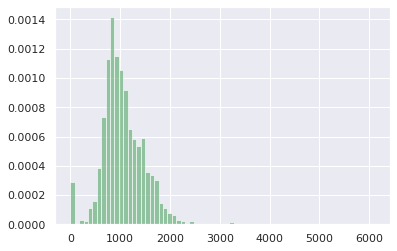

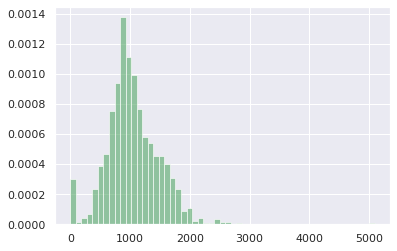

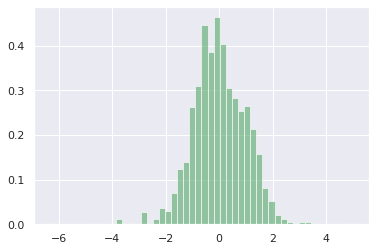

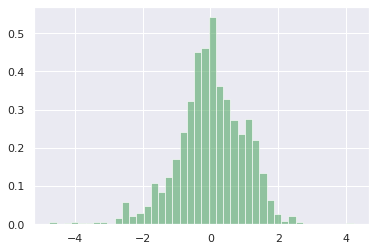

In [51]:
plot_histogram(df_train["TotalBsmtSF"])
plot_histogram(df_test["TotalBsmtSF"])
plot_histogram(newtrain["TotalBsmtSF"])
plot_histogram(newtest["TotalBsmtSF"])

## 3$^a$ Regressão

In [52]:
target=df_train["SalePrice"]

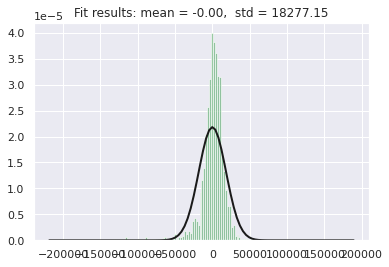

score: 0.9464985143962091
RMSE on Training set : 21557.68796875899
RMSE on Test set : 25445.334189353955


count    1.314000e+03
mean    -1.262495e-11
std      1.828411e+04
min     -2.000313e+05
25%     -5.625782e+03
50%      1.602674e+03
75%      8.670472e+03
max      1.708002e+05
Name: SalePrice, dtype: float64

In [53]:
features = newtrain.columns.drop("SalePrice") 

X_train, X_test, y_train, y_test = train_test_split(newtrain, target, test_size = 0.1, random_state = 0)
#print(X_train.shape)
#print(y_train.shape)

#X_train=newtrain
#y_train=target

#x_train=train[features]
lr = LinearRegression()
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
error = y_train_pred - y_train
#print(error)
#sns.displot(error, fit=norm)
plot_histogram(error, dofit=True)
print("score: "+ str(lr.score(X_train, y_train)))
print("RMSE on Training set :", rmse_cv_train(lr,X_train,y_train).mean())
print("RMSE on Test set :", rmse_cv_test(lr,X_test,y_test).mean())
error.describe()

In [54]:
target.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [55]:
trainprices=(lr.predict(X_train))
#print(trainprices.min())
X_train["SalePrices"]=trainprices
#X_train.describe()

In [56]:
testSalePrices=(lr.predict(newtest))
newtest["SalePrices"]=testSalePrices


In [57]:
X_train["SalePrices"].describe()

count      1314.000000
mean     181040.624049
std       76904.346876
min      -71730.530067
25%      131325.451819
50%      168551.092517
75%      221318.228077
max      554968.658078
Name: SalePrices, dtype: float64

In [58]:
newtest["SalePrices"].describe()

count      1459.000000
mean     180942.953661
std       71258.092714
min      -57051.205635
25%      136131.148735
50%      178468.474622
75%      221273.967159
max      484137.887147
Name: SalePrices, dtype: float64

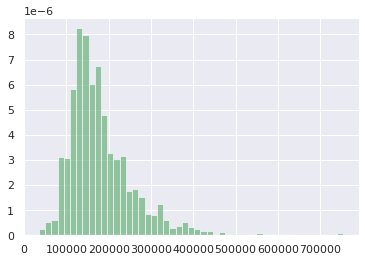

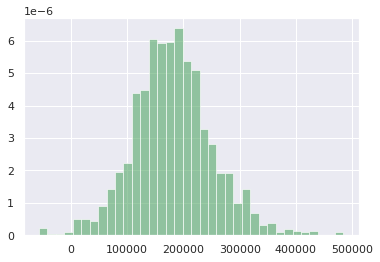

In [59]:
plot_histogram((target))
plot_histogram((newtest["SalePrices"]))

### Encontrando as features que geram os preços negativos

In [60]:
minprice=target.describe()["min"]
print(minprice)

34900.0


In [61]:
outliers = newtest[newtest['SalePrices'] < minprice]

In [62]:
outliers.describe()

LotFrontage    LotArea   LotShape  OverallQual  OverallCond  YearBuilt  \
count    32.000000  32.000000  32.000000    32.000000    32.000000  32.000000   
mean     -0.473418  -0.187611   0.422682    -1.533827    -2.152706  -1.013334   
std       1.506933   1.793577   0.661276     0.843189     1.187436   0.782085   
min      -3.367732  -3.537628  -1.089783    -3.534786    -4.088751  -2.348062   
25%      -0.748457  -0.753120   0.702768    -2.142815    -2.517468  -1.706405   
50%      -0.244766   0.163423   0.702768    -1.446829    -2.292999  -1.031843   
75%       0.230808   0.476253   0.702768    -0.750844    -1.395123  -0.439544   
max       1.976606   3.715427   0.702768    -0.054858    -0.497247   0.152755   

       YearRemodAdd  MasVnrArea  ExterQual  Foundation  ...  Has2ndFlr  \
count     32.000000   32.000000  32.000000   32.000000  ...  32.000000   
mean      -1.164209   -0.202822  -0.944305   -0.729632  ...   0.594133   
std        0.611035    0.176365   0.763737    0.760810  ...   0.923760   
min       -1.593092   -1.169200  -2.383060   -1.927757  ...  -0.859342   
25%       -1.593092   -0.171145  -0.677869   -1.328695  ...  -0.859342   
50%       -1.569430   -0.171145  -0.677869   -0.729632  ...   1.162884   
75%       -0.646592   -0.171145  -0.677869   -0.729632  ...   1.162884   
max        0.394559   -0.171145   1.027322    1.067554  ...   1.162884   

       HasMasVnr  MSSubClass_SC150  MSSubClass_SC20  HouseStyle_1Story  \
count  32.000000      3.200000e+01        32.000000          32.000000   
mean   -0.668826     -2.618016e-02        -0.381910          -0.583679   
std     0.504373      2.114977e-17         0.820097           0.839929   
min    -0.797003     -2.618016e-02        -0.769668          -1.021128   
25%    -0.797003     -2.618016e-02        -0.769668          -1.021128   
50%    -0.797003     -2.618016e-02        -0.769668          -1.021128   
75%    -0.797003     -2.618016e-02        -0.769668          -1.021128   
max     1.253840     -2.618016e-02         1.298371           0.978638   

       Exterior1st_VinylSd  MasVnrType_None  GarageType_Attchd  \
count            32.000000        32.000000          32.000000   
mean             -0.667315         0.730576          -0.552076   
std               0.370607         0.362776           0.955325   
min              -0.732830        -1.257464          -1.186013   
25%              -0.732830         0.794706          -1.186013   
50%              -0.732830         0.794706          -1.186013   
75%              -0.732830         0.794706           0.842583   
max               1.363638         0.794706           0.842583   

       GarageFinish_Unf    SalePrices  
count         32.000000     32.000000  
mean           0.460340   4263.298005  
std            0.974840  27647.617808  
min           -0.865382 -57051.205635  
25%           -0.865382  -1504.082616  
50%            1.154766  11328.273978  
75%            1.154766  22012.761519  
max            1.154766  33949.413203  

[8 rows x 52 columns]

In [63]:
meandif= outliers.mean()
print(meandif.nlargest(10))
print("")
print(meandif.nsmallest(20))

SalePrices          4263.298005
MasVnrType_None        0.730576
Has2ndFlr              0.594133
GarageFinish_Unf       0.460340
LotShape               0.422682
BedroomAbvGr           0.364238
BsmtUnfSF              0.082579
YrSold                 0.056881
MSSubClass_SC150      -0.026180
BsmtScore1            -0.066714
dtype: float64

OverallScore   -2.370661
OverallCond    -2.152706
OverallQual    -1.533827
GarageScore    -1.294993
YearRemodAdd   -1.164209
ExterScore     -1.074757
YearBuilt      -1.013334
KitchenQual    -0.960893
ExterQual      -0.944305
BsmtFinType1   -0.916523
GarageYrBlt    -0.883770
2ndFlrSF       -0.841645
GarageArea     -0.744451
Foundation     -0.729632
HeatingQC      -0.720800
AllFlrsSF      -0.712959
GarageCars     -0.707024
BsmtQual       -0.694866
HasFireplace   -0.686579
TotalBaths     -0.685152
dtype: float64


52
['SalePrices', 'LotFrontage', 'LotArea', 'LotShape', 'OverallQual', 'OverallCond']


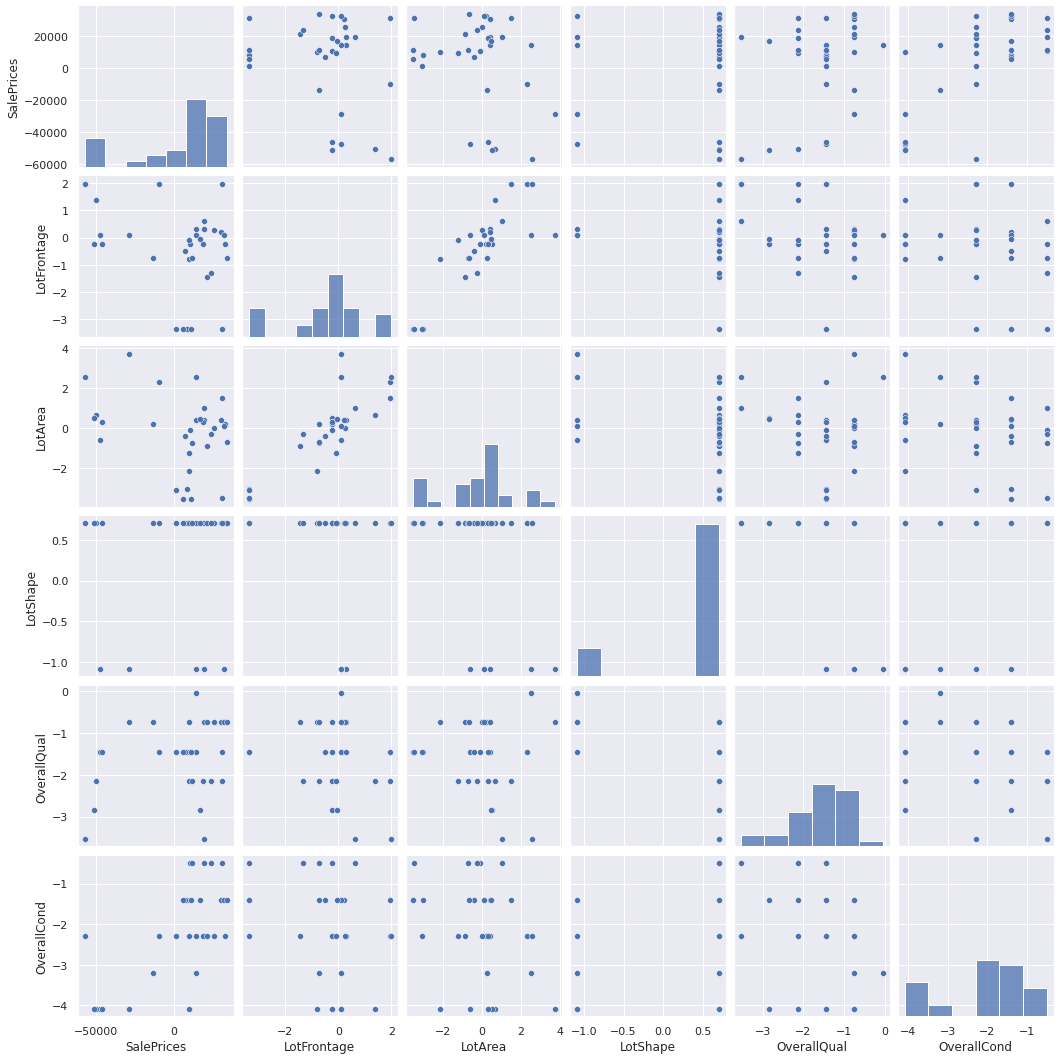




['SalePrices', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'Foundation']


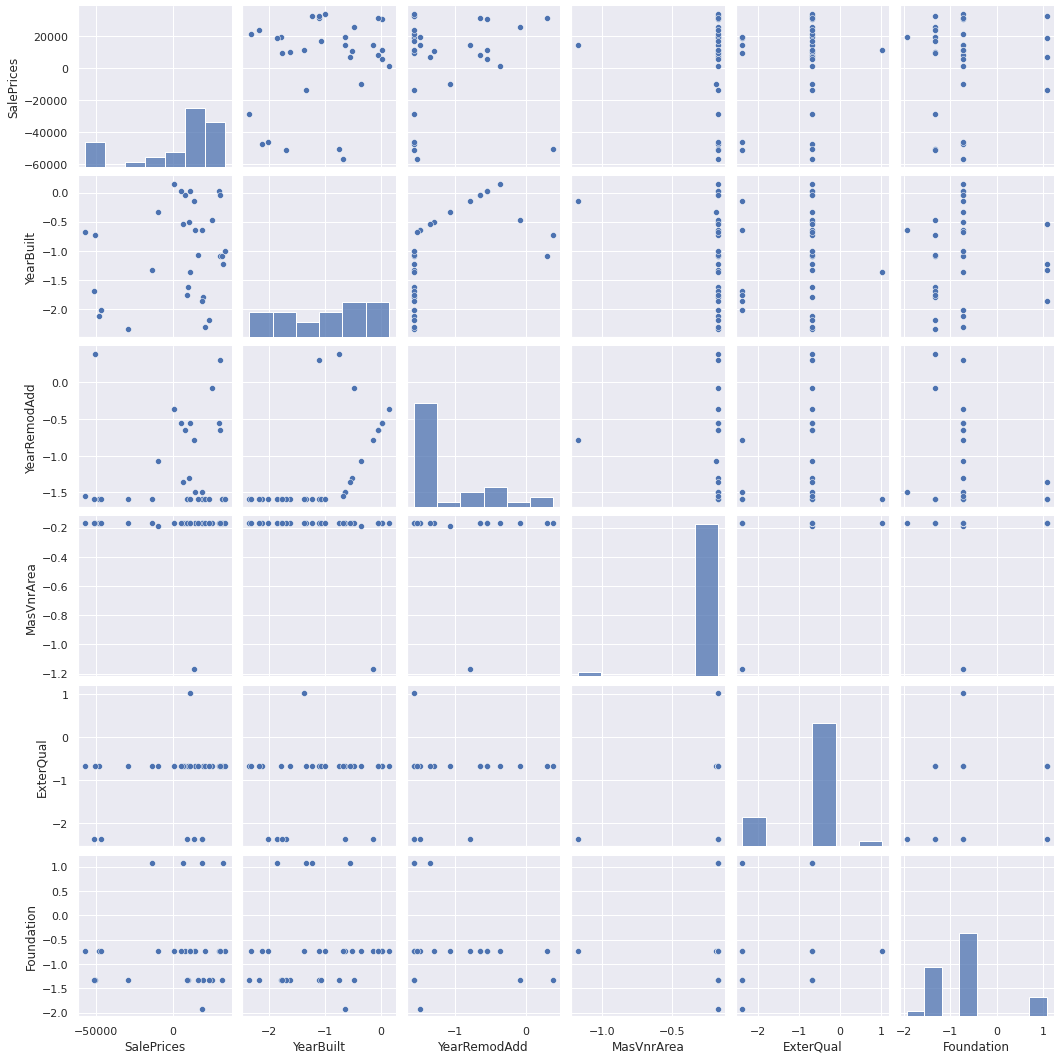




['SalePrices', 'BsmtQual', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF']


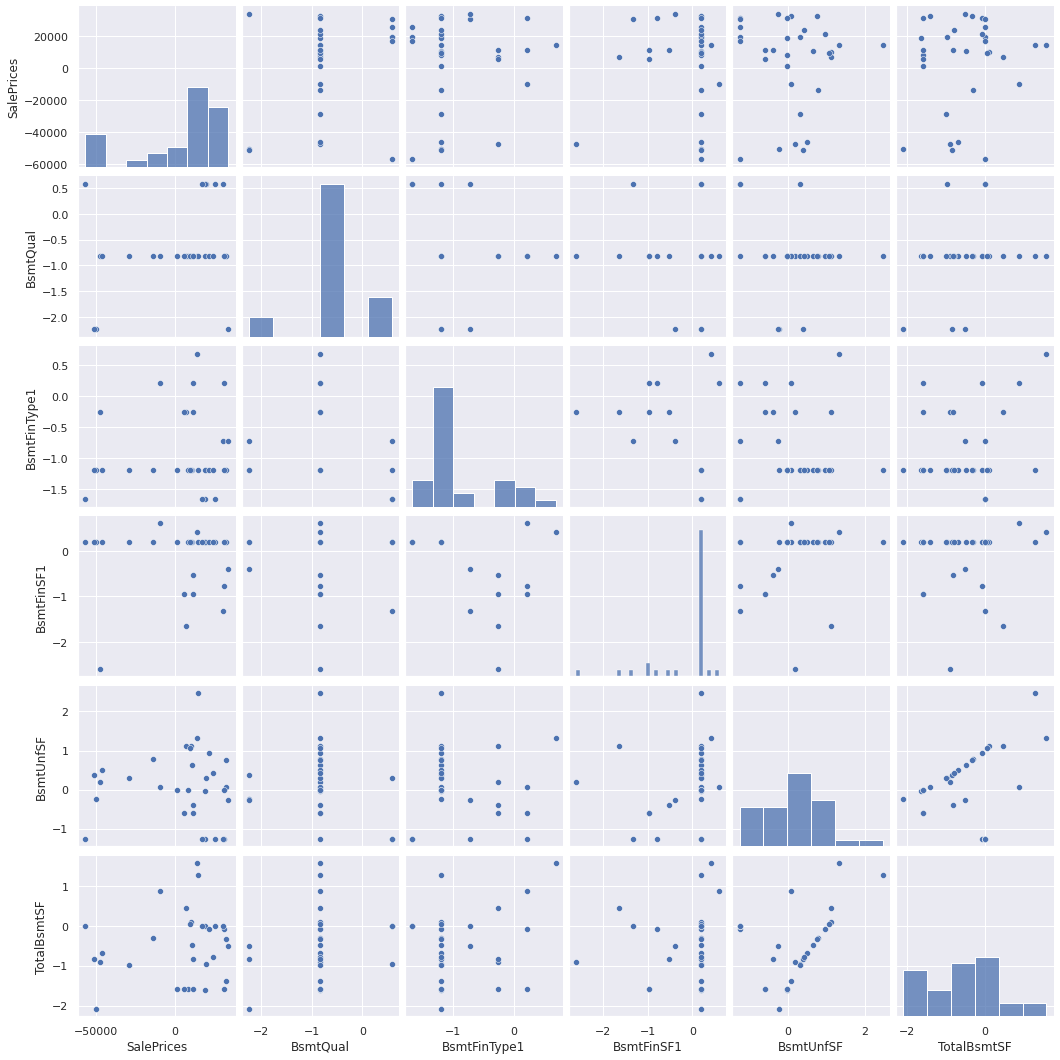




['SalePrices', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath']


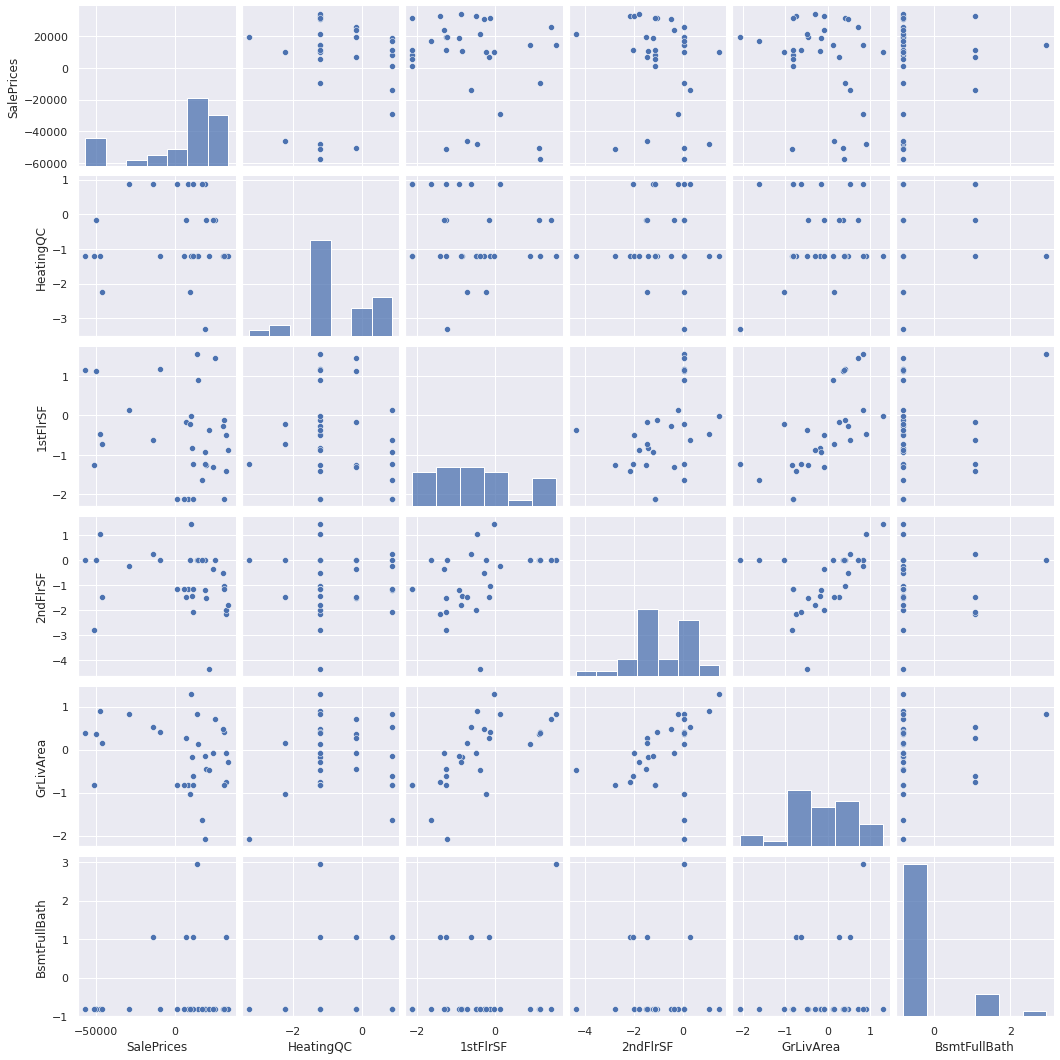




['SalePrices', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd']


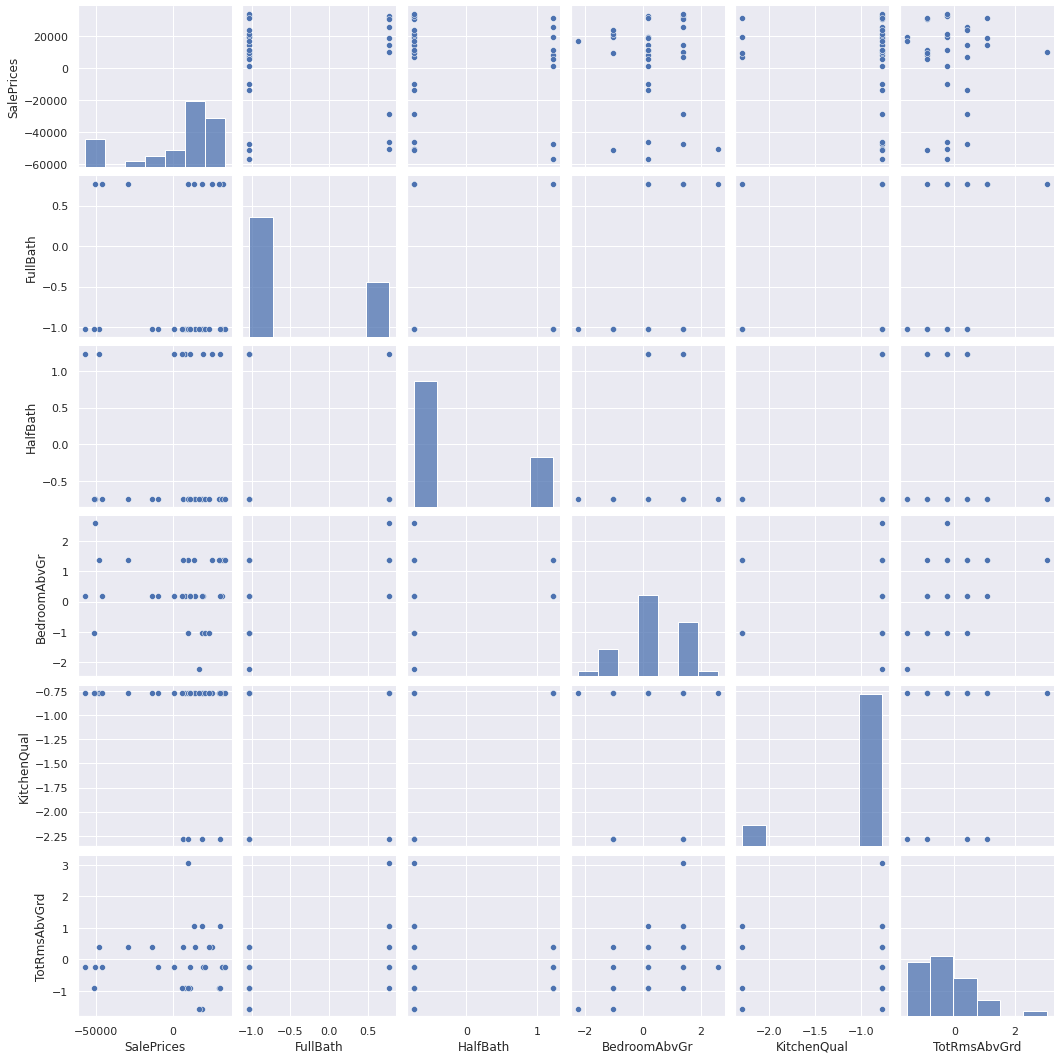




['SalePrices', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF']


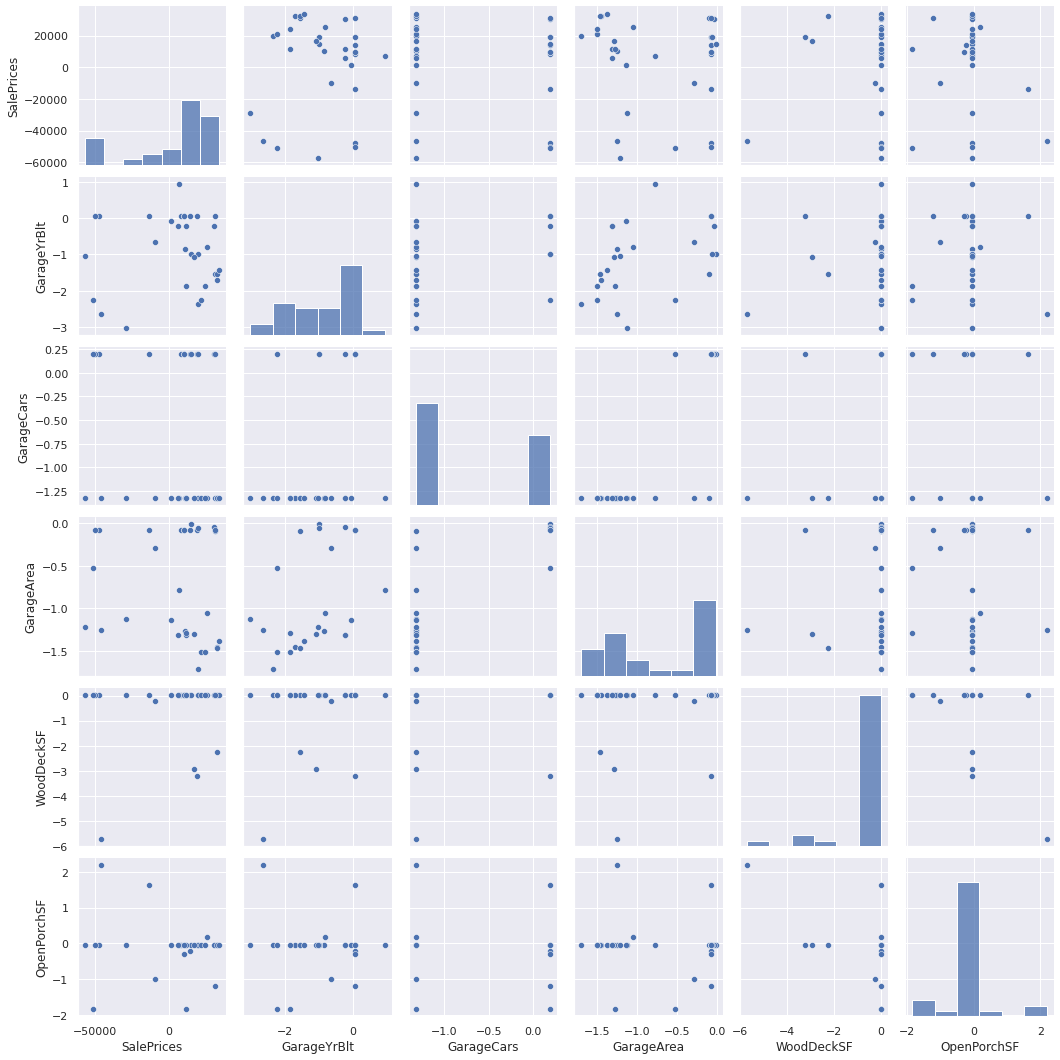




['SalePrices', 'YrSold', 'OverallScore', 'GarageScore', 'ExterScore', 'KitchenScore']


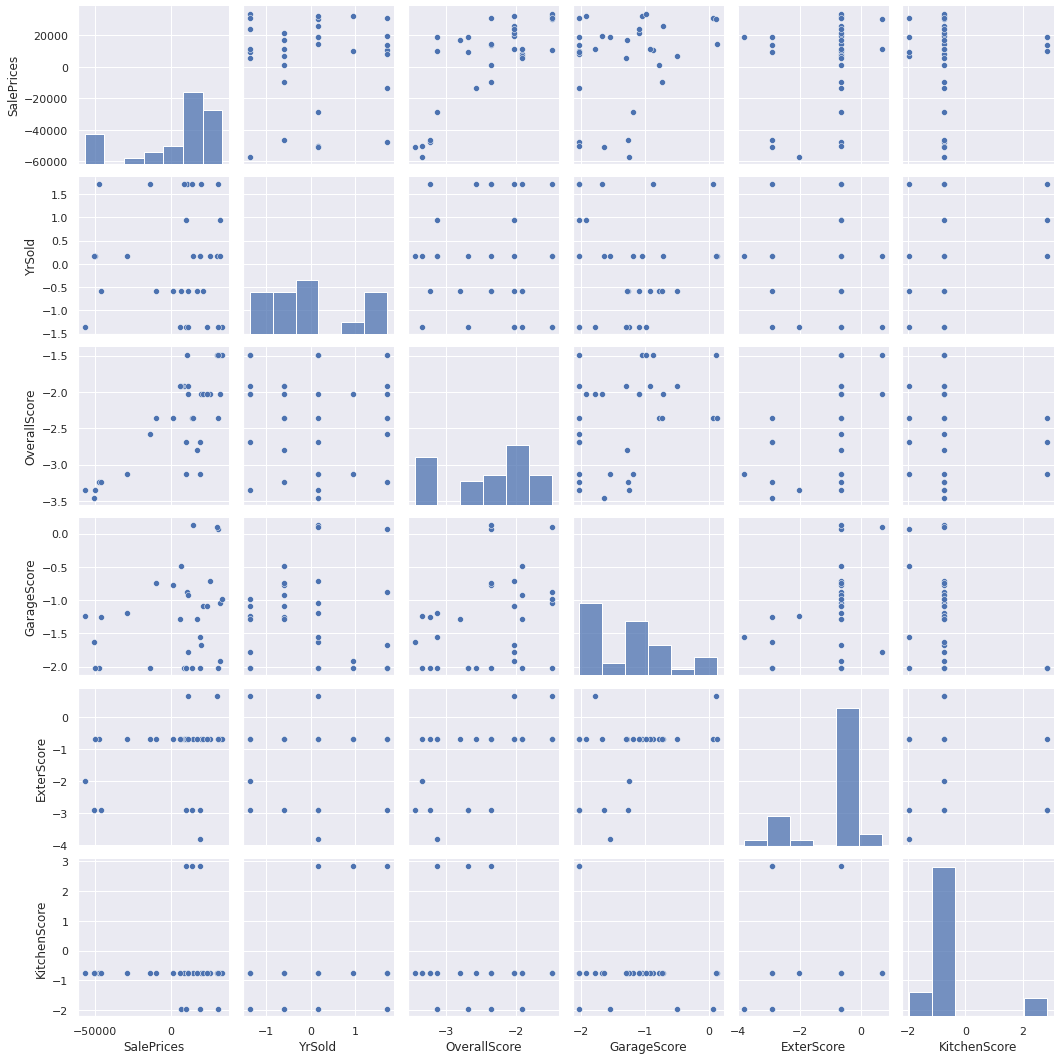




['SalePrices', 'LivArea/RmsAbvGrd', 'TotalBaths', 'BsmtScore1', 'AllSF', 'AllFlrsSF']


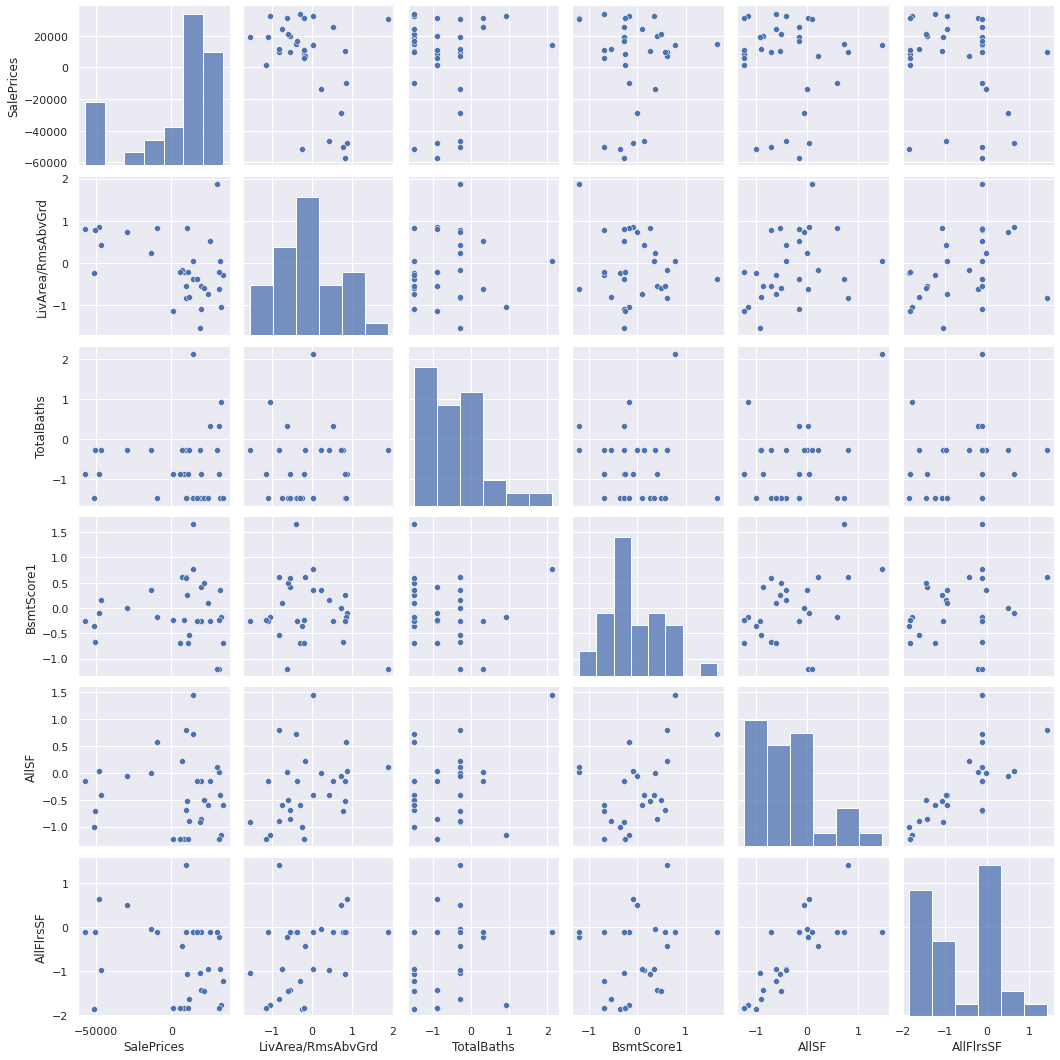




['SalePrices', 'HasWoodDeck', 'HasFireplace', 'Has2ndFlr', 'HasMasVnr', 'MSSubClass_SC150']


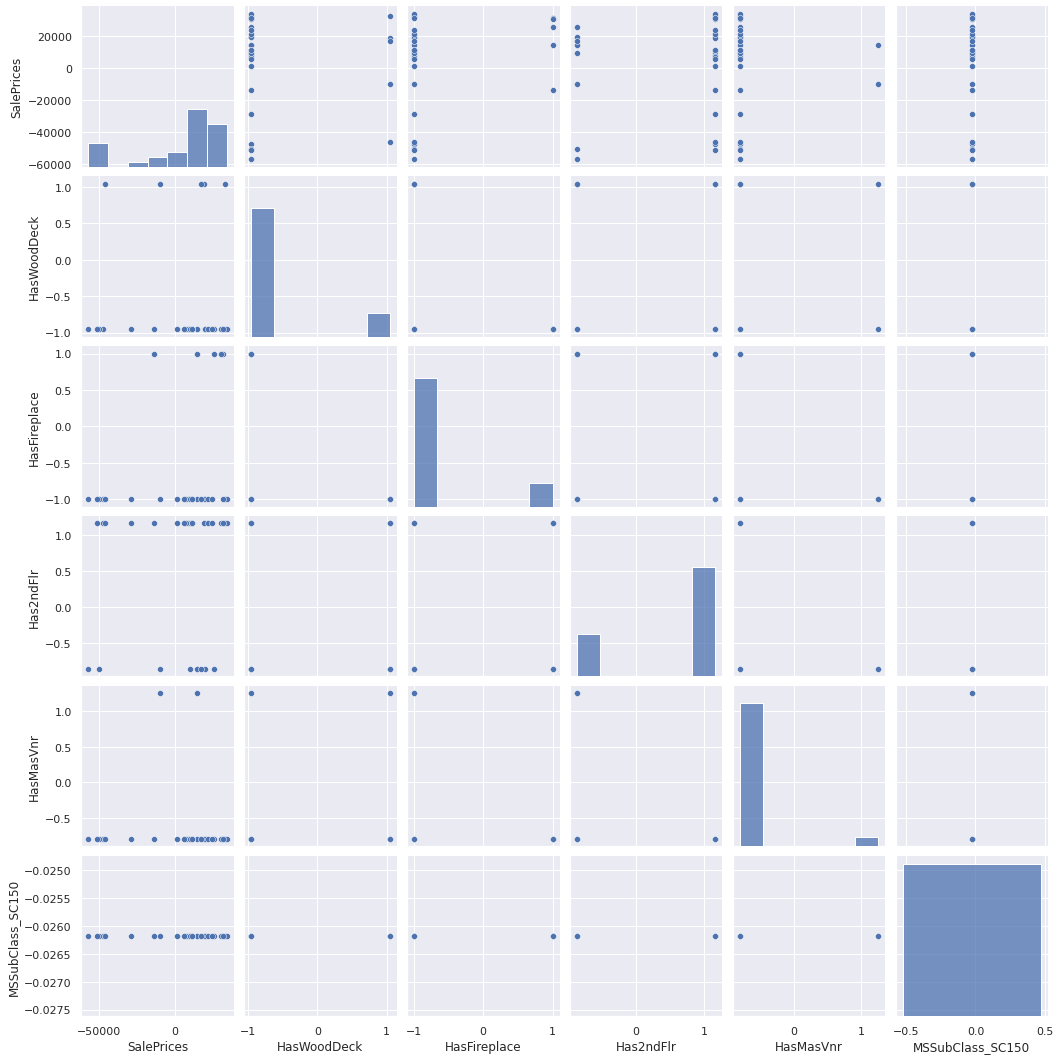




['SalePrices', 'MSSubClass_SC20', 'HouseStyle_1Story', 'Exterior1st_VinylSd', 'MasVnrType_None', 'GarageType_Attchd']


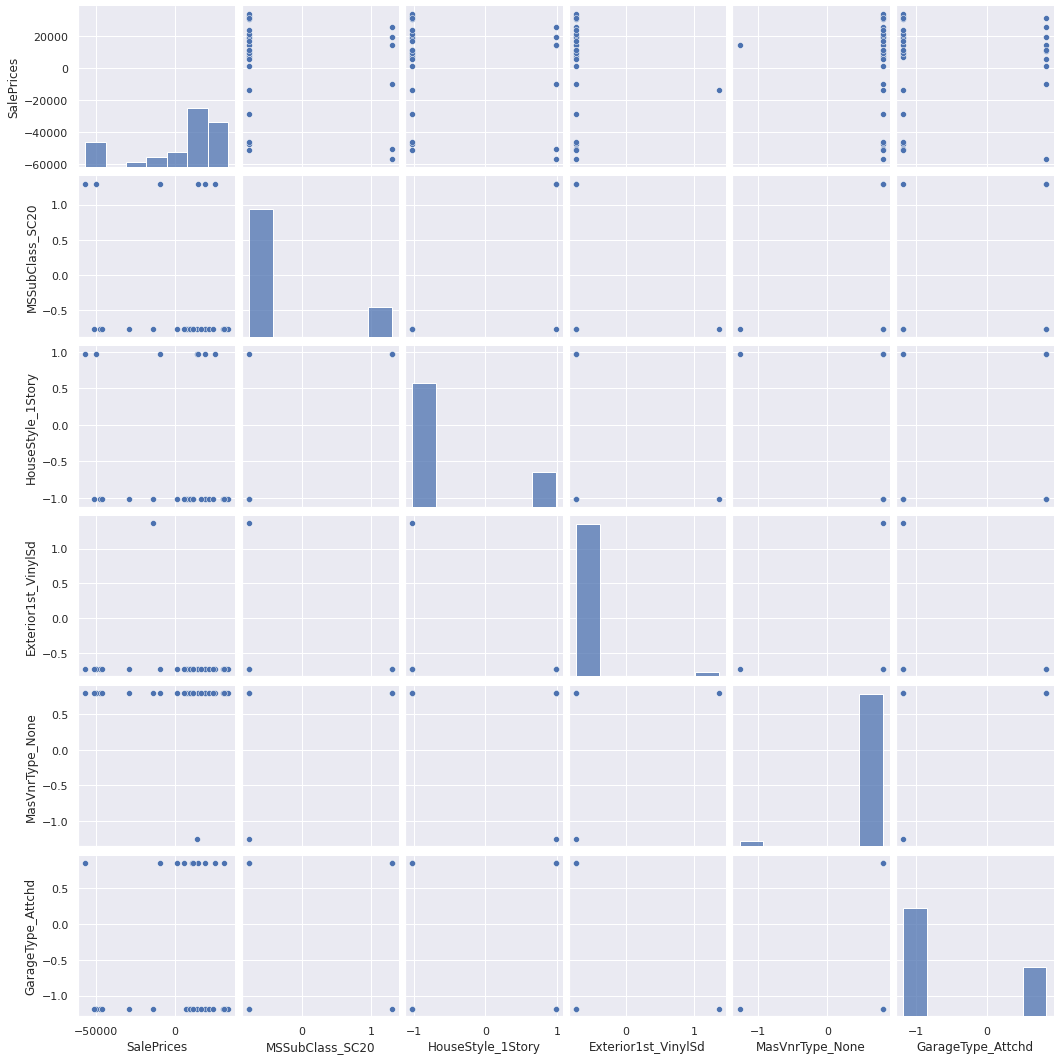

In [64]:
cols=outliers.columns
cols=cols.tolist()
#cols = [x for x in cls]
lcols=len(cols)
print(lcols)
for x in range(lcols//5):
    cls = ["SalePrices"] + cols[x*5:min((x+1)*5,lcols)]
    print(cls)
    sns.set()
    sns.pairplot((outliers[cls]), size = 2.5)
    plt.show()
    print("\n\n")

In [65]:
#outliers
probfeatures = []
for i in outliers.columns:
    counts = outliers[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(outliers) * 100 > 95:    #85 
        probfeatures.append(i)


probfeatures = list(probfeatures)
probfeatures.append("SalePrices")
probfeatures.append("SalePrice")
print("Dropped features: "+str(probfeatures))
newtrain = newtrain.drop(probfeatures, axis = 1, errors = "ignore")
newtest = newtest.drop(probfeatures, axis =1, errors = "ignore" )
print(len(newtrain.columns))
print(len(newtest.columns))
a=[x for x in newtrain.columns if (x not in newtest.columns)]
print(a)

Dropped features: ['MSSubClass_SC150', 'Exterior1st_VinylSd', 'MasVnrType_None', 'SalePrices', 'SalePrice']
48
48
[]


## 4$^a$ Regressão

In [66]:
target = np.log1p(target)

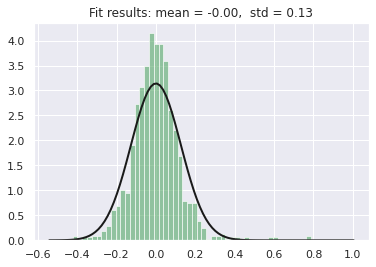

score: 0.9004461104156756
RMSE on Training set : 0.13889005225654522
RMSE on Test set : 0.13939332770168736


count    1.314000e+03
mean    -9.517163e-16
std      1.270248e-01
min     -4.712328e-01
25%     -7.202333e-02
50%     -4.040450e-03
75%      6.158107e-02
max      9.337884e-01
Name: SalePrice, dtype: float64

In [67]:
#features = newtrain.columns.drop("SalePrice") 

X_train, X_test, y_train, y_test = train_test_split(newtrain, target, test_size = 0.1, random_state = 0)
#print(X_train.shape)
#print(y_train.shape)

#X_train=newtrain
#y_train=target

#x_train=train[features]
lr = LinearRegression()
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
error = y_train_pred - y_train
#print(error)
#sns.displot(error, fit=norm)
plot_histogram(error, dofit=True)
print("score: "+ str(lr.score(X_train, y_train)))
print("RMSE on Training set :", rmse_cv_train(lr,X_train,y_train).mean())
print("RMSE on Test set :", rmse_cv_test(lr,X_test,y_test).mean())
error.describe()

In [68]:
newtest.describe()

LotFrontage       LotArea      LotShape   OverallQual   OverallCond  \
count  1.459000e+03  1.459000e+03  1.459000e+03  1.459000e+03  1.459000e+03   
mean  -7.858294e-14  2.430646e-14 -2.511128e-17 -4.392191e-16 -1.730396e-16   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -3.367732e+00 -3.556500e+00 -4.674884e+00 -3.534786e+00 -4.088751e+00   
25%   -2.447658e-01 -3.400791e-01 -1.089783e+00 -7.508438e-01 -4.972473e-01   
50%    8.789683e-02  1.386843e-01  7.027684e-01 -5.485835e-02 -4.972473e-01   
75%    5.470492e-01  5.436012e-01  7.027684e-01  6.411271e-01  4.006287e-01   
max    3.406741e+00  3.715427e+00  7.027684e-01  2.729083e+00  3.094257e+00   

          YearBuilt  YearRemodAdd    MasVnrArea     ExterQual    Foundation  \
count  1.459000e+03  1.459000e+03  1.459000e+03  1.459000e+03  1.459000e+03   
mean  -1.432865e-16  2.075980e-15 -2.509606e-16  1.811056e-17 -6.114978e-16   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -3.039077e+00 -1.593092e+00 -1.722809e+00 -2.383060e+00 -1.927757e+00   
25%   -6.040716e-01 -9.778668e-01 -1.711453e-01 -6.778691e-01 -7.296324e-01   
50%    5.403807e-02  3.945591e-01 -1.711453e-01 -6.778691e-01 -7.296324e-01   
75%    9.753916e-01  9.624594e-01 -1.711453e-01  1.027322e+00  1.067554e+00   
max    1.271541e+00  1.246410e+00  8.327919e+00  2.732514e+00  1.067554e+00   

       ...         AllSF     AllFlrsSF   HasWoodDeck  HasFireplace  \
count  ...  1.459000e+03  1.459000e+03  1.459000e+03  1.459000e+03   
mean   ...  6.315868e-17  2.527869e-16 -2.928128e-16  4.832019e-16   
std    ...  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min    ... -2.318524e+00 -3.173586e+00 -9.560707e-01 -9.989723e-01   
25%    ... -6.905496e-01 -1.109475e-01 -9.560707e-01 -9.989723e-01   
50%    ... -1.523106e-01 -1.109475e-01 -9.560707e-01 -9.989723e-01   
75%    ...  5.516425e-01 -1.109475e-01  1.045231e+00  1.000343e+00   
max    ...  1.011135e+01  6.285304e+00  1.045231e+00  1.000343e+00   

          Has2ndFlr     HasMasVnr  MSSubClass_SC20  HouseStyle_1Story  \
count  1.459000e+03  1.459000e+03     1.459000e+03       1.459000e+03   
mean   6.209335e-17 -3.952364e-16    -8.400865e-17      -9.740133e-18   
std    1.000000e+00  1.000000e+00     1.000000e+00       1.000000e+00   
min   -8.593419e-01 -7.970035e-01    -7.696678e-01      -1.021128e+00   
25%   -8.593419e-01 -7.970035e-01    -7.696678e-01      -1.021128e+00   
50%   -8.593419e-01 -7.970035e-01    -7.696678e-01       9.786380e-01   
75%    1.162884e+00  1.253840e+00     1.298371e+00       9.786380e-01   
max    1.162884e+00  1.253840e+00     1.298371e+00       9.786380e-01   

       GarageType_Attchd  GarageFinish_Unf  
count       1.459000e+03      1.459000e+03  
mean       -5.524482e-17     -5.265760e-17  
std         1.000000e+00      1.000000e+00  
min        -1.186013e+00     -8.653825e-01  
25%        -1.186013e+00     -8.653825e-01  
50%         8.425834e-01     -8.653825e-01  
75%         8.425834e-01      1.154766e+00  
max         8.425834e-01      1.154766e+00  

[8 rows x 48 columns]

In [69]:
testSalePrices=np.exp(lr.predict(newtest))
newtest["SalePrices"]=testSalePrices


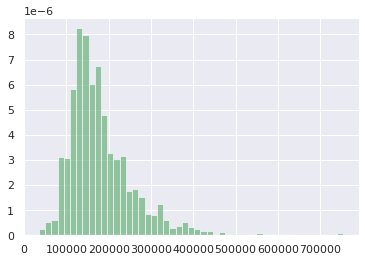

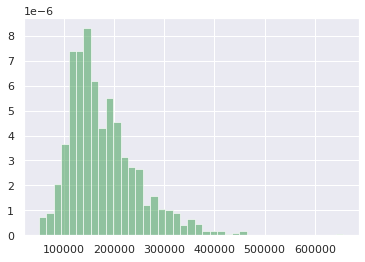

In [70]:
plot_histogram(np.exp(target))
plot_histogram((newtest["SalePrices"]))

In [71]:
#testids["SalePrice"]=newtest["SalePrices"]
result=pd.DataFrame(testids)
result["SalePrice"]=newtest["SalePrices"]
result.describe()

Id      SalePrice
count  1459.000000    1459.000000
mean   2190.000000  178479.313897
std     421.321334   69624.000528
min    1461.000000   50586.496788
25%    1825.500000  128997.958545
50%    2190.000000  162493.722477
75%    2554.500000  212536.514416
max    2919.000000  656521.094210

In [72]:
#result.to_csv("./result5.csv",index=False)